In [23]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 11 00:00:44 2025

@author: JP
"""
# -*- coding: utf-8 -*-
"""
Week 7 – Part 0: Setup & Data Collection (CLEAN VERSION)
Pulls prices, volume, market cap; runs DQ checks; cleans with ffill/bfill.
"""

## 0.1 Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D


# Machine Learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Data Collection
import yfinance as yf


warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120

print("="*80)
print("DeFi Portfolio Clustering & Analysis – Week 7 (Part 0: Data Collection)")
print("="*80)
print(f"Run at: {datetime.now():%Y-%m-%d %H:%M:%S}\n")

# =============================================================================
# 0.2 Universe & Dates
# =============================================================================
TICKERS = [
    'AMZN','AAPL','META','GOOGL','GOOG','NFLX','NVDA','MSFT','PLTR','ORCL','AVGO',
    'DIS','VZ',
    'TSLA','HD','MCD','SBUX',
    'WMT','PG','KO','PEP','CL',
    'MDLZ',
    'COST',
    'XOM','CVX','COP','MPC',
    'BRK-B','JPM','BAC','GS','V','MA',
    'LLY','JNJ','PFE','ABBV','BMY',
    'GE','CAT','HON','DE','BA',
    'LIN','NEM',
    'NEE','DUK',
    'CSCO','CRM'
]
assert len(TICKERS) == 50, "Expected exactly 50 tickers"

START_DATE = "2024-09-02"
END_DATE   = "2025-10-31"

print(f"Universe size: {len(TICKERS)}")
print(f"Date range: {START_DATE} → {END_DATE}  (~{pd.bdate_range(START_DATE, END_DATE).shape[0]} bdays)\n")

# =============================================================================
# 0.3 Helpers
# =============================================================================
def _extract_panel_field(df: pd.DataFrame, field: str) -> pd.DataFrame:
    """
    Extracts a price 'field' from yf.download output robustly for multi or single tickers.
    Returns a (Date x Ticker) DataFrame.
    """
    if isinstance(df.columns, pd.MultiIndex):
        # Newer yfinance: level-0 = field ('Adj Close','Close','Volume'), level-1 = ticker
        if field in df.columns.get_level_values(0):
            out = df[field].copy()
        else:
            raise KeyError(f"Field '{field}' not found in columns: {df.columns.levels[0].tolist()}")
    else:
        # Single-ticker case
        if field in df.columns:
            out = df[[field]].copy()
            # Name that single column with the ticker if we can infer it
            # yfinance sets df.attrs.get('tickers') sometimes – fallback to 'TICKER'
            guess = df.columns.name or 'TICKER'
            out.columns = [guess]
        else:
            raise KeyError(f"Field '{field}' not found in columns: {df.columns.tolist()}")
    return out

def _sanitize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Drop all-NaN columns and report."""
    before = df.shape[1]
    df2 = df.dropna(axis=1, how="all")
    dropped = [c for c in df.columns if c not in df2.columns]
    if dropped:
        print(f"⚠️ Dropped {len(dropped)} tickers with no data: {', '.join(dropped)}")
    if before != df2.shape[1]:
        print(f"Columns before/after: {before} → {df2.shape[1]}")
    return df2

def _shares_outstanding_for(tick: str) -> float:
    """
    Get shares outstanding using fast_info (preferred). Fallback to .info if needed.
    Returns np.nan on failure.
    """
    try:
        t = yf.Ticker(tick)
        so = getattr(t, "fast_info", {}).get("shares_outstanding", None)
        if so is not None and np.isfinite(so) and so > 0:
            return float(so)
        # Fallback (slower / sometimes deprecated)
        inf = getattr(t, "info", {})
        so2 = inf.get("sharesOutstanding", None)
        if so2 is not None and np.isfinite(so2) and so2 > 0:
            return float(so2)
    except Exception:
        pass
    return np.nan

def _compute_market_cap(close_df: pd.DataFrame) -> pd.DataFrame:
    """
    Market cap time-series = Close * shares_outstanding (assumed static over the window).
    """
    print("\nFetching shares outstanding for market cap...")
    shares_map = {}
    for tick in close_df.columns:
        so = _shares_outstanding_for(tick)
        shares_map[tick] = so
    # Report missing
    missing = [k for k,v in shares_map.items() if not np.isfinite(v)]
    if missing:
        print(f"⚠️ Missing shares_outstanding for {len(missing)} tickers: {', '.join(missing)}")

    # Build Market Cap DF
    mcap = pd.DataFrame(index=close_df.index, columns=close_df.columns, dtype=float)
    for tick in close_df.columns:
        so = shares_map.get(tick, np.nan)
        if np.isfinite(so):
            mcap[tick] = close_df[tick] * so
        else:
            mcap[tick] = np.nan
    return mcap

# =============================================================================
# 0.4 Download (robust)
# =============================================================================
def download_stock_data(tickers, start_date, end_date):
    """
    Robust multi-ticker download:
    - pulls full panel once,
    - extracts Close (prefers Adj Close if available) and Volume,
    - drops empty columns,
    - builds market cap from shares outstanding.
    """
    print("Downloading price panel from Yahoo Finance...")
    data = yf.download(
        tickers,
        start=start_date, end=end_date,
        auto_adjust=False, progress=False,
        group_by="column", threads=True
    )

    if data is None or data.empty:
        raise RuntimeError("yf.download returned empty DataFrame. Check tickers and date range.")

    # Prefer 'Adj Close' if present; else 'Close'
    has_adj = isinstance(data.columns, pd.MultiIndex) and ("Adj Close" in data.columns.get_level_values(0))
    try:
        close_raw  = _extract_panel_field(data, "Adj Close" if has_adj else "Close")
        volume_raw = _extract_panel_field(data, "Volume")
    except KeyError as e:
        # Very rare structures: try to re-download each ticker individually as fallback
        print(f"Panel extract failed ({e}). Falling back to per-ticker loop...")
        close_pieces, volume_pieces = [], []
        for t in tickers:
            try:
                dti = yf.download(t, start=start_date, end=end_date, auto_adjust=False, progress=False)
                if dti is None or dti.empty:
                    continue
                c = dti["Adj Close"] if "Adj Close" in dti.columns else dti["Close"]
                v = dti["Volume"]
                close_pieces.append(c.rename(t))
                volume_pieces.append(v.rename(t))
            except Exception:
                continue
        if not close_pieces:
            raise RuntimeError("Per-ticker fallback also failed; all downloads empty.")
        close_raw  = pd.concat(close_pieces, axis=1).sort_index()
        volume_raw = pd.concat(volume_pieces, axis=1).sort_index()

    # Sanitize (drop all-NaN columns)
    close_df  = _sanitize_columns(close_raw)
    volume_df = _sanitize_columns(volume_raw)

    # Align indices & columns
    close_df, volume_df = close_df.sort_index(), volume_df.reindex(close_df.index)
    volume_df = volume_df[close_df.columns]

    # Compute Market Cap (may contain NaNs where shares missing)
    market_cap_df = _compute_market_cap(close_df)

    print("\nShapes:")
    print(f"  Close:      {close_df.shape}")
    print(f"  Volume:     {volume_df.shape}")
    print(f"  Market Cap: {market_cap_df.shape}")

    return {"close": close_df, "volume": volume_df, "market_cap": market_cap_df}

raw_data = download_stock_data(TICKERS, START_DATE, END_DATE)

print("\n" + "-"*80)
print("DATA DOWNLOAD COMPLETE")
print("-"*80)
print(f"\nClose Prices Shape: {raw_data['close'].shape}")
print(f"Volume Shape:       {raw_data['volume'].shape}")
print(f"Market Cap Shape:   {raw_data['market_cap'].shape}")

# =============================================================================
# 0.5 Data Quality Assessment
# =============================================================================
def assess_data_quality(data_dict):
    close_df  = data_dict["close"]
    volume_df = data_dict["volume"]
    mktcap_df = data_dict["market_cap"]

    if close_df.shape[1] == 0:
        raise ValueError("No valid tickers with Close prices. (All empty after download.)")

    print("\n" + "-"*80)
    print("DATA QUALITY ASSESSMENT")
    print("-"*80)

    # Count missing per column
    close_missing  = close_df.isna().sum()
    volume_missing = volume_df.isna().sum()
    mktcap_missing = mktcap_df.isna().sum()

    def _report(name, s):
        nz = s[s > 0]
        print(f"\n{name}:")
        if nz.empty:
            print("  No missing values ✓")
        else:
            print(f"  Missing values in {len(nz)} tickers:")
            print(nz.sort_values(ascending=False).to_string())

    _report("Close", close_missing)
    _report("Volume", volume_missing)
    _report("Market Cap", mktcap_missing)

    # Basic stats for Close (first rows of describe)
    print("\nSummary Stats – Close (first rows):")
    print(close_df.describe().iloc[:3].to_string())

    return close_missing, volume_missing, mktcap_missing

_ = assess_data_quality(raw_data)

# =============================================================================
# 0.6 Cleaning (ffill/bfill)
# =============================================================================
def clean_data(data_dict, method="ffill"):
    """
    Forward-fill + back-fill to handle occasional gaps; align indices/columns.
    """
    print("\n" + "-"*80)
    print("CLEANING DATA")
    print("-"*80)

    cleaned = {}
    for key, df in data_dict.items():
        if df.empty:
            cleaned[key] = df.copy()
            continue

        if method == "ffill":
            out = df.ffill().bfill()
        elif method == "interpolate":
            out = df.interpolate(limit_direction="both").ffill().bfill()
        else:
            out = df.copy()

        cleaned[key] = out

    # Ensure perfect alignment
    idx = cleaned["close"].index
    cols = cleaned["close"].columns
    cleaned["volume"]     = cleaned["volume"].reindex(idx)[cols]
    cleaned["market_cap"] = cleaned["market_cap"].reindex(idx)[cols]

    print(f"\nFinal dataset shape (Close): {cleaned['close'].shape}")
    print(f"Date range: {idx[0].date()} → {idx[-1].date()}  | trading days: {len(idx)}")

    # Report any residual NaNs
    resid = cleaned["close"].isna().sum().sum() + \
            cleaned["volume"].isna().sum().sum() + \
            cleaned["market_cap"].isna().sum().sum()
    if resid > 0:
        print(f"⚠️ Residual NaNs after cleaning: {int(resid)} (mostly from missing shares→mktcap).")

    return cleaned

clean_data_dict = clean_data(raw_data, method="ffill")

print("\n" + "="*80)
print("PART 0 COMPLETE ✅  (Prices, Volume, Market Cap ready)")
print("="*80)


DeFi Portfolio Clustering & Analysis – Week 7 (Part 0: Data Collection)
Run at: 2025-11-11 22:49:35

Universe size: 50
Date range: 2024-09-02 → 2025-10-31  (~305 bdays)


Fetching shares outstanding for market cap...

Shapes:
  Close:      (292, 50)
  Volume:     (292, 50)
  Market Cap: (292, 50)

--------------------------------------------------------------------------------
DATA DOWNLOAD COMPLETE
--------------------------------------------------------------------------------

Close Prices Shape: (292, 50)
Volume Shape:       (292, 50)
Market Cap Shape:   (292, 50)

--------------------------------------------------------------------------------
DATA QUALITY ASSESSMENT
--------------------------------------------------------------------------------

Close:
  No missing values ✓

Volume:
  No missing values ✓

Market Cap:
  No missing values ✓

Summary Stats – Close (first rows):
Ticker        AAPL        ABBV        AMZN        AVGO          BA         BAC         BMY       BRK-B   

<h3 style="color:#004488; font-weight:700; margin-top:12px;">
Task 1 — Data Collection & Preparation
</h3>

<p style="font-size:16px; line-height:1.45;">
We constructed a dataset of <b>50 U.S. large-cap equities</b> across multiple sectors to serve as the basis for our analysis. 
Daily market data was retrieved from <b>Yahoo Finance</b> for the period <b>2024-09-02</b> to <b>2025-10-31</b> (~305 trading days). 
For each security, we collected:
</p>

<ul style="font-size:16px; line-height:1.45; margin-top:4px;">
  <li><b>Adjusted Close Prices</b> (used for return estimation)</li>
  <li><b>Daily Trading Volume</b> (liquidity profile indicator)</li>
  <li><b>Market Capitalization</b> (computed via Shares Outstanding)</li>
</ul>

<p style="font-size:16px; line-height:1.45;">
Data was downloaded programmatically, validated for completeness, and aligned on a common trading calendar.
A <b>data quality check</b> confirmed that no missing observations were present across price, volume, or market capitalization time series.
Thus, no forward/backward imputation was needed beyond standard alignment.
</p>

<table style="font-size:16px; border-collapse: collapse; width:100%; margin-top:8px;">
  <thead>
    <tr style="border-bottom: 2px solid #004488; background-color:#E8F4FA;">
      <th style="text-align:left; padding:8px;">Dataset Component</th>
      <th style="text-align:left; padding:8px;">Shape</th>
      <th style="text-align:left; padding:8px;">Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;">Adjusted Close Prices</td>
      <td style="padding:8px;">(292 × 50)</td>
      <td style="padding:8px;">Daily price history for each equity</td>
    </tr>
    <tr style="background-color:#F5F5F7;">
      <td style="padding:8px;">Trading Volume</td>
      <td style="padding:8px;">(292 × 50)</td>
      <td style="padding:8px;">Liquidity and market activity profile</td>
    </tr>
    <tr>
      <td style="padding:8px;">Market Capitalization</td>
      <td style="padding:8px;">(292 × 50)</td>
      <td style="padding:8px;">Market value computed using shares outstanding</td>
    </tr>
  </tbody>
</table>

<p style="font-size:16px; line-height:1.45; margin-top:14px;">
<b>Result:</b> The dataset is clean, consistent, and ready for return computation and feature engineering.
</p>






In [24]:
# =============================================================================
# PART 1: FEATURE ENGINEERING (ROBUST VERSION)
# =============================================================================
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

print("\n" + "=" * 80)
print("PART 1: FEATURE ENGINEERING")
print("=" * 80 + "\n")

# -----------------------------
# 0) Sanity checks & alignment
# -----------------------------
def _require_clean_dict(d):
    if not isinstance(d, dict):
        raise ValueError("clean_data_dict must be a dict with keys: 'close', 'volume', 'market_cap' (optional).")
    if 'close' not in d or 'volume' not in d:
        raise KeyError("clean_data_dict must include at least 'close' and 'volume'.")
    # Allow market_cap to be missing; we'll try to build it below.
    for k in ['close', 'volume'] + (['market_cap'] if 'market_cap' in d else []):
        if not isinstance(d[k], pd.DataFrame):
            raise TypeError(f"clean_data_dict['{k}'] must be a pandas DataFrame.")

def _coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    return df.apply(pd.to_numeric, errors='coerce')

def _align_and_fill(d: dict) -> dict:
    # Align on common index & columns that actually exist in both frames
    close  = _coerce_numeric(d['close']).copy()
    volume = _coerce_numeric(d['volume']).copy()

    # Build/validate market_cap
    if 'market_cap' in d and isinstance(d['market_cap'], pd.DataFrame):
        market_cap = _coerce_numeric(d['market_cap']).copy()
    else:
        market_cap = None
        if 'shares_outstanding' in d and isinstance(d['shares_outstanding'], pd.DataFrame):
            so = _coerce_numeric(d['shares_outstanding']).copy()
            # Align shares outstanding to close columns if possible
            common_cols = close.columns.intersection(so.columns)
            if len(common_cols) > 0:
                market_cap = (close[common_cols] * so[common_cols])
                print("ℹ️ Built 'market_cap' = price × shares_outstanding for common tickers.")
        if market_cap is None:
            # Create empty DF with same shape as close; will fill with NaN means later
            market_cap = pd.DataFrame(index=close.index, columns=close.columns, dtype=float)
            print("⚠️ 'market_cap' missing; proceeding with NaNs (we'll handle in aggregation).")

    # Determine common index (intersection) across the three frames
    common_index = close.index.intersection(volume.index).intersection(market_cap.index)
    close  = close.loc[common_index].sort_index()
    volume = volume.loc[common_index].sort_index()
    market_cap = market_cap.loc[common_index].sort_index()

    # Keep only tickers present in both close & volume (and intersect with mcap)
    common_cols = close.columns.intersection(volume.columns).intersection(market_cap.columns)
    close  = close[common_cols]
    volume = volume[common_cols]
    market_cap = market_cap[common_cols]

    # Forward/Backward fill per column to address small gaps; keep leading all-NaN as NaN
    close  = close.ffill().bfill()
    volume = volume.ffill().bfill()
    market_cap = market_cap.ffill().bfill()

    return {'close': close, 'volume': volume, 'market_cap': market_cap}

# Expectation: clean_data_dict exists from previous step
try:
    _require_clean_dict(clean_data_dict)
except Exception as e:
    raise RuntimeError(f"[PART 1] Precondition failed: {e}")

clean_data_dict = _align_and_fill(clean_data_dict)

# --------------------------------
# 1.1 Calculate Returns (log)
# --------------------------------
print("Calculating returns...")

def calculate_returns(prices_df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate daily log returns.
    """
    prices_df = prices_df.sort_index()
    returns = np.log(prices_df / prices_df.shift(1))
    returns = returns.replace([np.inf, -np.inf], np.nan)
    return returns.dropna(how="all")

returns = calculate_returns(clean_data_dict['close'])
print(f"Returns shape: {returns.shape}")
print("\nFirst 5 rows of returns:")
try:
    print(returns.head().to_string())
except Exception:
    print(returns.head())

# ----------------------------------------
# 1.2 Rolling (annualized) volatilities
# ----------------------------------------
print("\n" + "-" * 80)
print("Calculating rolling volatilities...")
print("-" * 80 + "\n")

def calculate_rolling_volatility(returns_df: pd.DataFrame, windows=[5, 10, 22]) -> dict:
    """
    Calculate rolling volatility (annualized) with min_periods=window.
    """
    volatilities = {}
    for window in windows:
        vol = returns_df.rolling(window=window, min_periods=window).std() * np.sqrt(252.0)
        volatilities[f'volatility_{window}d'] = vol
        print(f"✓ Calculated {window}-day rolling volatility")
    return volatilities

volatilities = calculate_rolling_volatility(returns, windows=[5, 10, 22])

# ----------------------------------------
# 1.3 Construct Feature Matrix (per ticker)
# ----------------------------------------
print("\n" + "-" * 80)
print("CONSTRUCTING FEATURE MATRIX")
print("-" * 80 + "\n")

def construct_feature_matrix(data_dict: dict, returns_df: pd.DataFrame, volatilities_dict: dict) -> pd.DataFrame:
    """
    Features per stock:
      1. avg_return           (mean of daily log returns)
      2. avg_volume           (mean daily volume)
      3. avg_market_cap       (mean daily market cap)
      4. avg_volatility_5d    (mean of 5d rolling annualized vol)
      5. avg_volatility_10d   (mean of 10d rolling annualized vol)
      6. avg_volatility_22d   (mean of 22d rolling annualized vol)
    """
    close = data_dict['close']
    volume = data_dict['volume']
    market_cap = data_dict['market_cap']

    # Work only on tickers that exist across all inputs
    tickers = close.columns.intersection(volume.columns).intersection(market_cap.columns)
    tickers = tickers.intersection(returns_df.columns)

    # Also ensure tickers exist in each volatility DF
    for key in ['volatility_5d', 'volatility_10d', 'volatility_22d']:
        tickers = tickers.intersection(volatilities_dict[key].columns)

    if len(tickers) == 0:
        raise RuntimeError("No overlapping tickers across price/volume/market_cap/returns/volatility matrices.")

    features = {}
    for ticker in tickers:
        features[ticker] = {
            'avg_return': returns_df[ticker].mean(skipna=True),
            'avg_volume': volume[ticker].mean(skipna=True),
            'avg_market_cap': market_cap[ticker].mean(skipna=True),
            'avg_volatility_5d': volatilities_dict['volatility_5d'][ticker].mean(skipna=True),
            'avg_volatility_10d': volatilities_dict['volatility_10d'][ticker].mean(skipna=True),
            'avg_volatility_22d': volatilities_dict['volatility_22d'][ticker].mean(skipna=True),
        }

    features_df = pd.DataFrame(features).T

    # If market_cap was missing and stayed NaN for some tickers, leave NaN and fill with column means
    features_df = features_df.apply(pd.to_numeric, errors='coerce')
    features_df = features_df.fillna(features_df.mean(numeric_only=True))

    print("Feature Matrix Summary:")
    print("-" * 40)
    print(f"Shape: {features_df.shape}")
    print(f"\nFeatures: {list(features_df.columns)}")
    print("\nFirst 5 rows:")
    try:
        print(features_df.head().to_string())
    except Exception:
        print(features_df.head())

    print("\n\nDescriptive Statistics:")
    try:
        print(features_df.describe().to_string())
    except Exception:
        print(features_df.describe())

    return features_df

# Construct feature matrix
X_features = construct_feature_matrix(clean_data_dict, returns, volatilities)

# ----------------------------------------
# 1.4 Data Preprocessing Documentation
# ----------------------------------------
print("\n" + "-" * 80)
print("DATA PREPROCESSING SUMMARY")
print("-" * 80 + "\n")

print("Data Sources:")
print("  - Price data: Yahoo Finance API")
print("  - Volume data: Yahoo Finance API")
print("  - Market Cap: Price × Shares Outstanding (if available), else provided in clean_data_dict")

print("\nPreprocessing Steps:")
print("  1. Downloaded daily data for target tickers")
print("  2. Aligned indices/columns across price, volume, (market cap)")
print("  3. Handled missing values with forward-fill and backward-fill")
print("  4. Calculated daily log returns")
print("  5. Calculated rolling volatilities (5d, 10d, 22d; annualized, min_periods=window)")
print("  6. Aggregated per-ticker features via time-series means")
print(f"  7. Constructed feature matrix: {X_features.shape[0]} stocks × {X_features.shape[1]} features")

# ----------------------------------------
# Save feature matrix
# ----------------------------------------
out_path = 'feature_matrix.csv'
print("\nSaving feature matrix to CSV...")
X_features.to_csv(out_path, index=True)
print(f"✓ Saved as '{out_path}'")

# =============================================================================
# SAVE CHECKPOINT
# =============================================================================
print("\n" + "=" * 80)
print("CHECKPOINT: Data collection and feature engineering complete!")
print("=" * 80 + "\n")


PART 1: FEATURE ENGINEERING

Calculating returns...
Returns shape: (291, 50)

First 5 rows of returns:
Ticker          AAPL      ABBV      AMZN      AVGO        BA       BAC       BMY     BRK-B       CAT        CL       COP      COST       CRM      CSCO       CVX        DE       DIS       DUK        GE      GOOG     GOOGL        GS        HD       HON       JNJ       JPM        KO       LIN       LLY        MA       MCD      MDLZ      META       MPC      MSFT       NEE       NEM      NFLX      NVDA      ORCL       PEP       PFE        PG      PLTR      SBUX      TSLA         V        VZ       WMT       XOM
Date                                                                                                                                                                                                                                                                                                                                                                                             

<h3 style="color:#004488; font-weight:700; margin-top:12px;">
Task 2 — Feature Engineering
</h3>

<p style="font-size:16px; line-height:1.45;">
To characterize the behavior of each asset in the investment universe, we derived a set of descriptive statistical features from the time-series data. These features summarize the <b>return dynamics</b>, <b>liquidity</b>, <b>firm scale</b>, and <b>volatility structure</b> of each security. Daily log-returns were calculated from Adjusted Close prices, ensuring comparability across stocks with dividends, splits, and corporate actions properly adjusted.
</p>

<p style="font-size:16px; line-height:1.45; margin-bottom:4px;">
The following per-ticker metrics were computed and then averaged across the historical window:
</p>

<ul style="font-size:16px; line-height:1.45;">
  <li><b>Average Daily Return</b> — baseline measure of price appreciation behavior</li>
  <li><b>Average Trading Volume</b> — proxy for liquidity and investor activity</li>
  <li><b>Average Market Capitalization</b> — proxy for firm size and weight in market indices</li>
  <li><b>5-day Rolling Volatility</b> — short–term price variability (≈ 1 week)</li>
  <li><b>10-day Rolling Volatility</b> — medium-term price variability (≈ 2 weeks)</li>
  <li><b>22-day Rolling Volatility</b> — monthly price variability (≈ 1 month)</li>
</ul>

<p style="font-size:16px; line-height:1.45;">
All volatilities were computed from daily log-returns and annualized. These six features constitute the <b>feature matrix</b>, with shape <b>(50 stocks × 6 features)</b>, forming the basis for PCA dimensionality reduction and K-Means clustering in subsequent steps.
</p>

<table style="font-size:16px; border-collapse: collapse; width:100%; margin-top:8px;">
  <thead>
    <tr style="border-bottom: 2px solid #004488; background-color:#E8F4FA;">
      <th style="text-align:left; padding:8px;">Feature</th>
      <th style="text-align:left; padding:8px;">Economic Interpretation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;">avg_return</td>
      <td style="padding:8px;">Expected price appreciation (momentum indicator)</td>
    </tr>
    <tr style="background-color:#F5F5F7;">
      <td style="padding:8px;">avg_volume</td>
      <td style="padding:8px;">Liquidity depth and investor participation</td>
    </tr>
    <tr>
      <td style="padding:8px;">avg_market_cap</td>
      <td style="padding:8px;">Firm size and relative market influence</td>
    </tr>
    <tr style="background-color:#F5F5F7;">
      <td style="padding:8px;">avg_volatility_5d</td>
      <td style="padding:8px;">Short-term price uncertainty (fast risk component)</td>
    </tr>
    <tr>
      <td style="padding:8px;">avg_volatility_10d</td>
      <td style="padding:8px;">Intermediate risk dynamics (stabilizes noise)</td>
    </tr>
    <tr style="background-color:#F5F5F7;">
      <td style="padding:8px;">avg_volatility_22d</td>
      <td style="padding:8px;">Monthly risk factor used in clustering and PCA scaling</td>
    </tr>
  </tbody>
</table>

<p style="font-size:16px; margin-top:14px; line-height:1.45;">
<b>Result:</b> We now have a consistent and economically interpretable multi-factor feature representation for each stock. 
This feature matrix will be standardized and used as input to PCA to compress the dimensionality while preserving the dominant drivers of variation.
</p>





PART 2: PRINCIPAL COMPONENT ANALYSIS (PCA)

--------------------------------------------------------------------------------
STEP 2.1: DATA STANDARDIZATION
--------------------------------------------------------------------------------

Why Standardization?
  PCA is sensitive to the scale of features. Features with larger
  magnitudes (e.g., market cap in billions) would dominate the analysis.
  Standardization ensures all features contribute equally.

Original Data (first 5 stocks):
      avg_return    avg_volume  avg_market_cap  avg_volatility_5d  avg_volatility_10d  avg_volatility_22d
AAPL    0.000694  5.372606e+07    3.334516e+12           0.245338            0.265885            0.280445
ABBV    0.000639  6.217297e+06    3.374454e+11           0.225803            0.242073            0.261879
AMZN    0.000806  4.253022e+07    2.249037e+12           0.288135            0.300600            0.312604
AVGO    0.003144  2.669677e+07    1.103765e+12           0.446742            0.476620

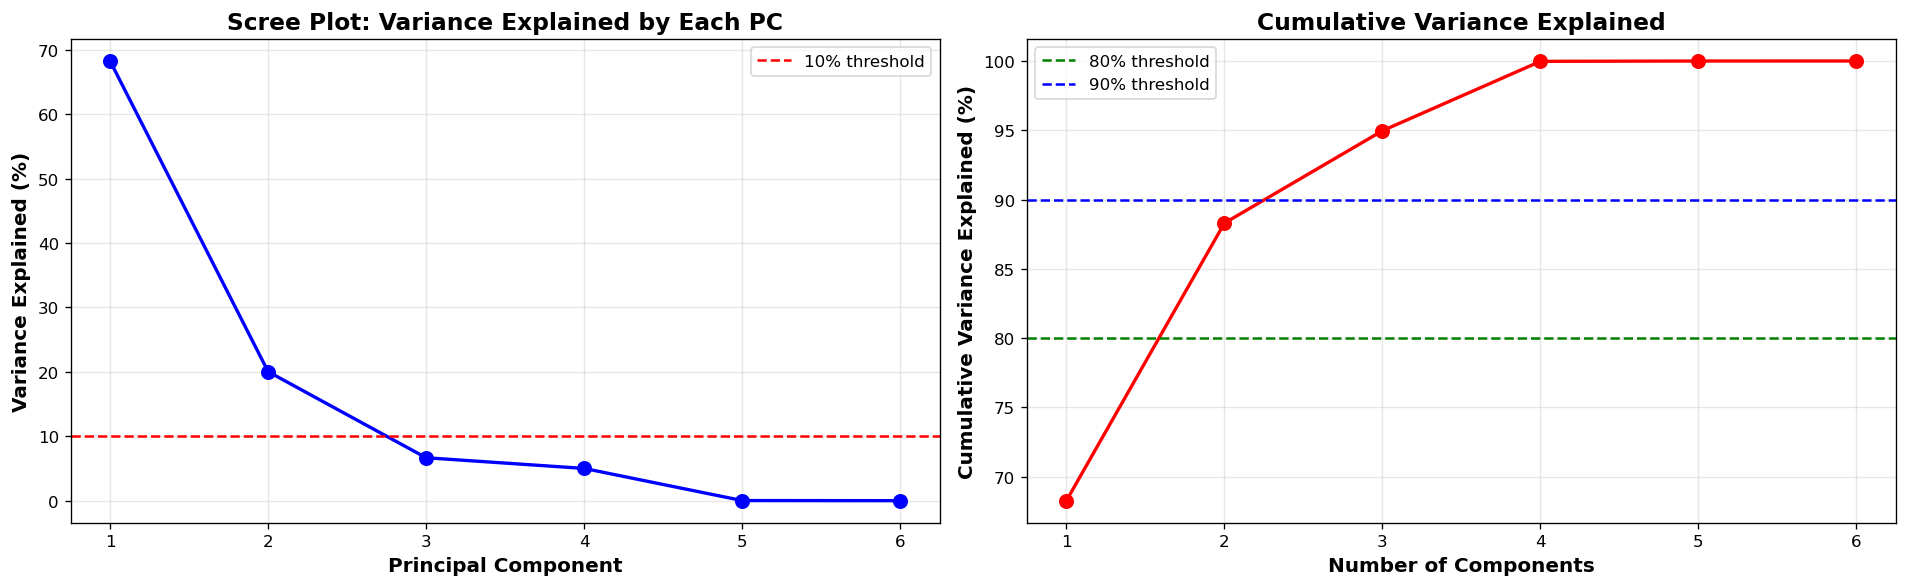

Scree Plot saved as 'pca_scree_plot.png'

Optimal Number of Components (different criteria):
  - Kaiser Criterion (Eigenvalue > 1): 2 components
  - 80% Variance Explained: 2 components
  - 90% Variance Explained: 3 components

✓ Selected 2 components (explains 88.30% of variance)

--------------------------------------------------------------------------------
STEP 2.4: FITTING PCA WITH 2 COMPONENTS
--------------------------------------------------------------------------------

Principal Component Scores (first 10 stocks):
            PC1       PC2
AAPL   0.908441  3.132558
ABBV  -0.592928 -0.293643
AMZN   1.088957  1.714252
AVGO   3.913432 -0.894941
BA     0.484026 -0.868181
BAC   -0.233388  0.145125
BMY   -0.467347 -0.470973
BRK-B -1.779456  0.488460
CAT    0.087391 -0.789844
CL    -1.880498 -0.088394


PC Scores Shape: (50, 2)
Variance Explained: 88.30%

--------------------------------------------------------------------------------
STEP 2.5: INTERPRETING PRINCIPAL COMPONENTS
--

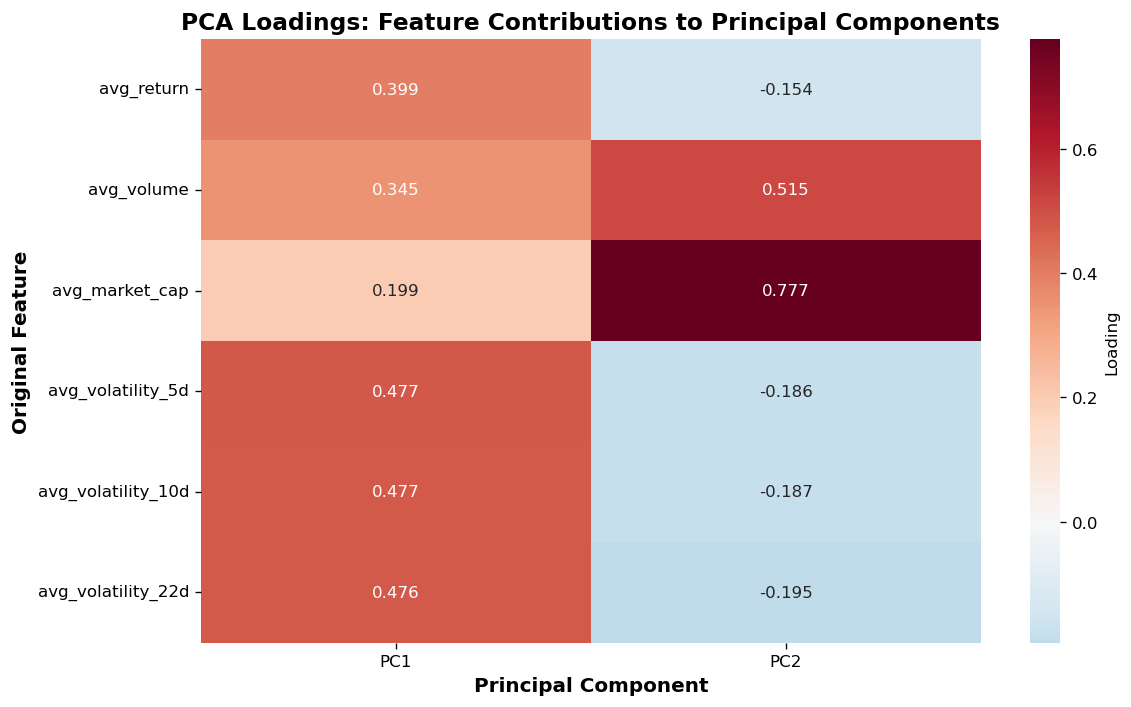


Loadings heatmap saved as 'pca_loadings_heatmap.png'

--------------------------------------------------------------------------------
INTERPRETATION OF PRINCIPAL COMPONENTS:
--------------------------------------------------------------------------------

PC1 (explains 68.27% of variance):
  Highest positive loadings:
    avg_volatility_5d        : +0.477
    avg_volatility_10d       : +0.477
    avg_volatility_22d       : +0.476
  Highest negative loadings:
    avg_return               : +0.399
    avg_volume               : +0.345
    avg_market_cap           : +0.199
  → Interpretation: Likely represents 'Risk/Volatility Factor'
    (volatility measures vs returns)

PC2 (explains 20.03% of variance):
  Highest positive loadings:
    avg_market_cap           : +0.777
    avg_volume               : +0.515
    avg_return               : -0.154
  Highest negative loadings:
    avg_volatility_5d        : -0.186
    avg_volatility_10d       : -0.187
    avg_volatility_22d       : -0.195

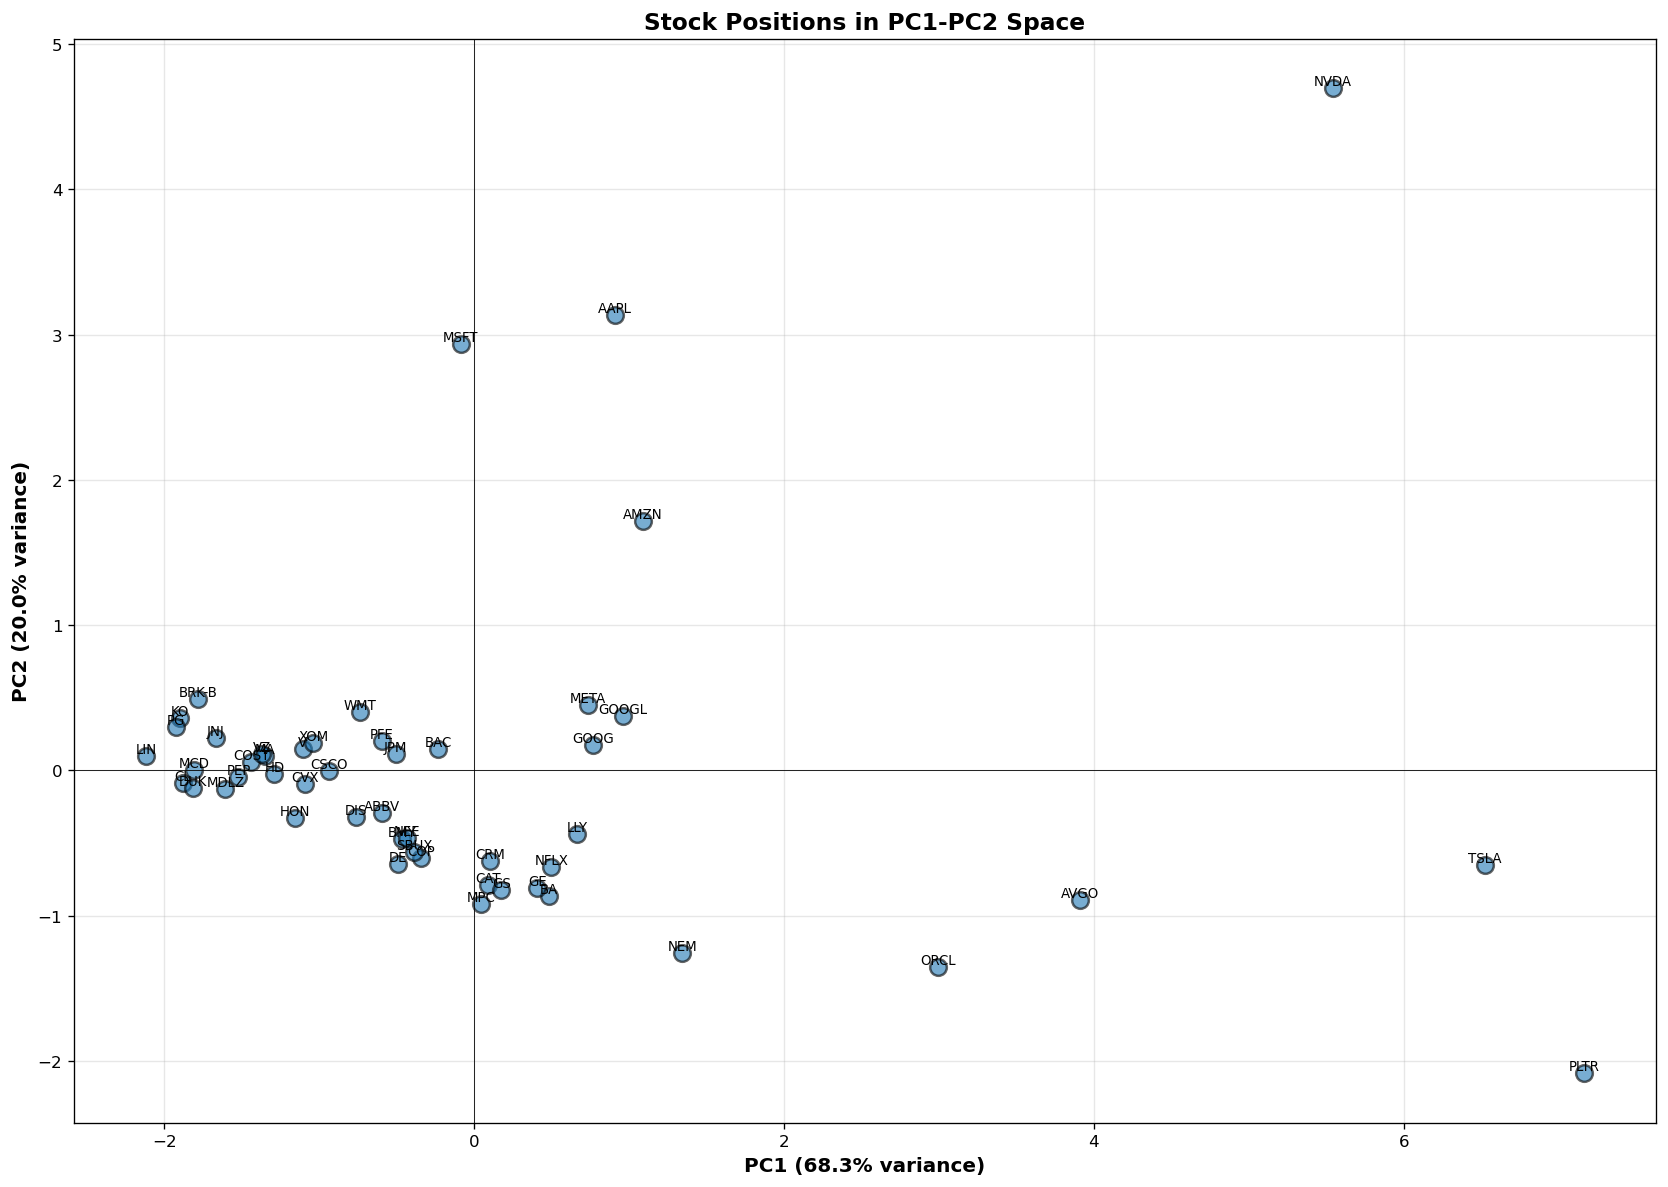

2D scatter plot saved as 'pca_2d_scatter.png'

PART 2.7: ADVANCED 3D FEATURE VISUALIZATION

--------------------------------------------------------------------------------
CREATING 3D SCATTER PLOTS WITH ORIGINAL FEATURES
--------------------------------------------------------------------------------

--- 3D Plot 1: Returns vs Volatility (22d) vs Market Cap ---


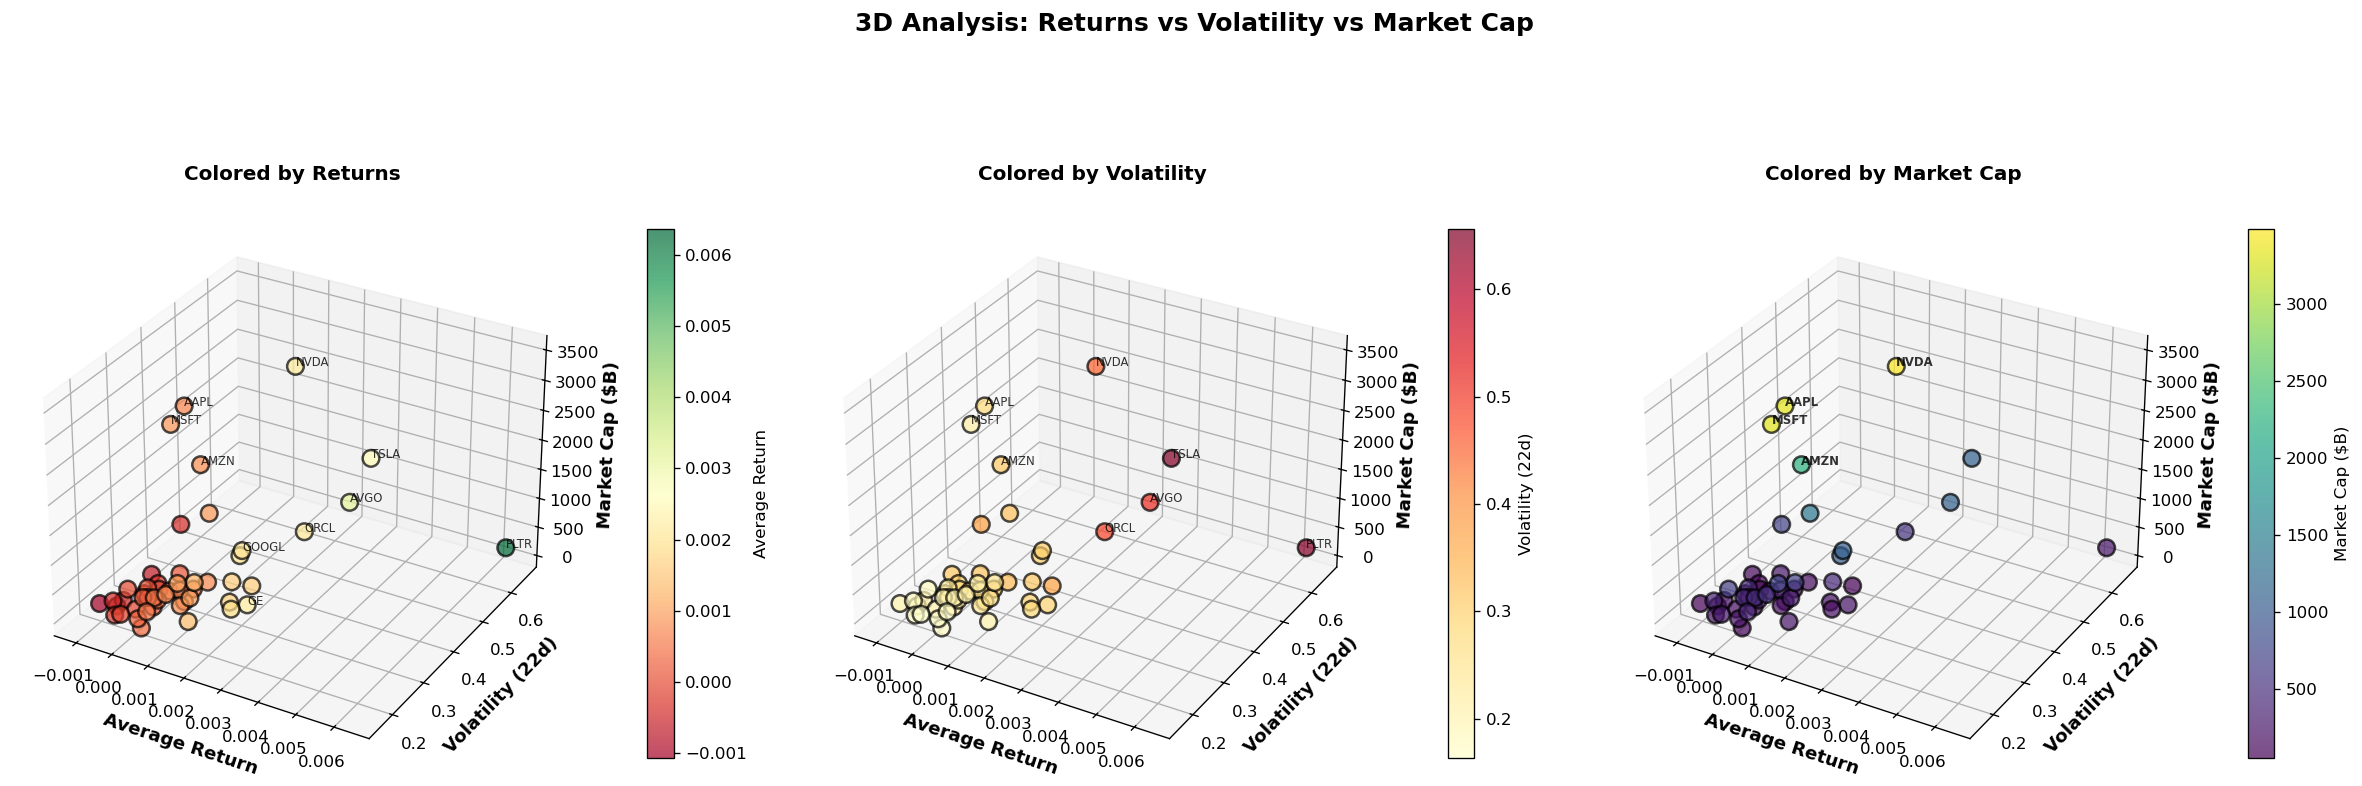

✓ Created 3D plot: Returns vs Volatility vs Market Cap
  - Plot saved as: plot_3d_returns_volatility_marketcap.png

--- 3D Plot 2: Returns vs Volume vs Volatility (22d) ---


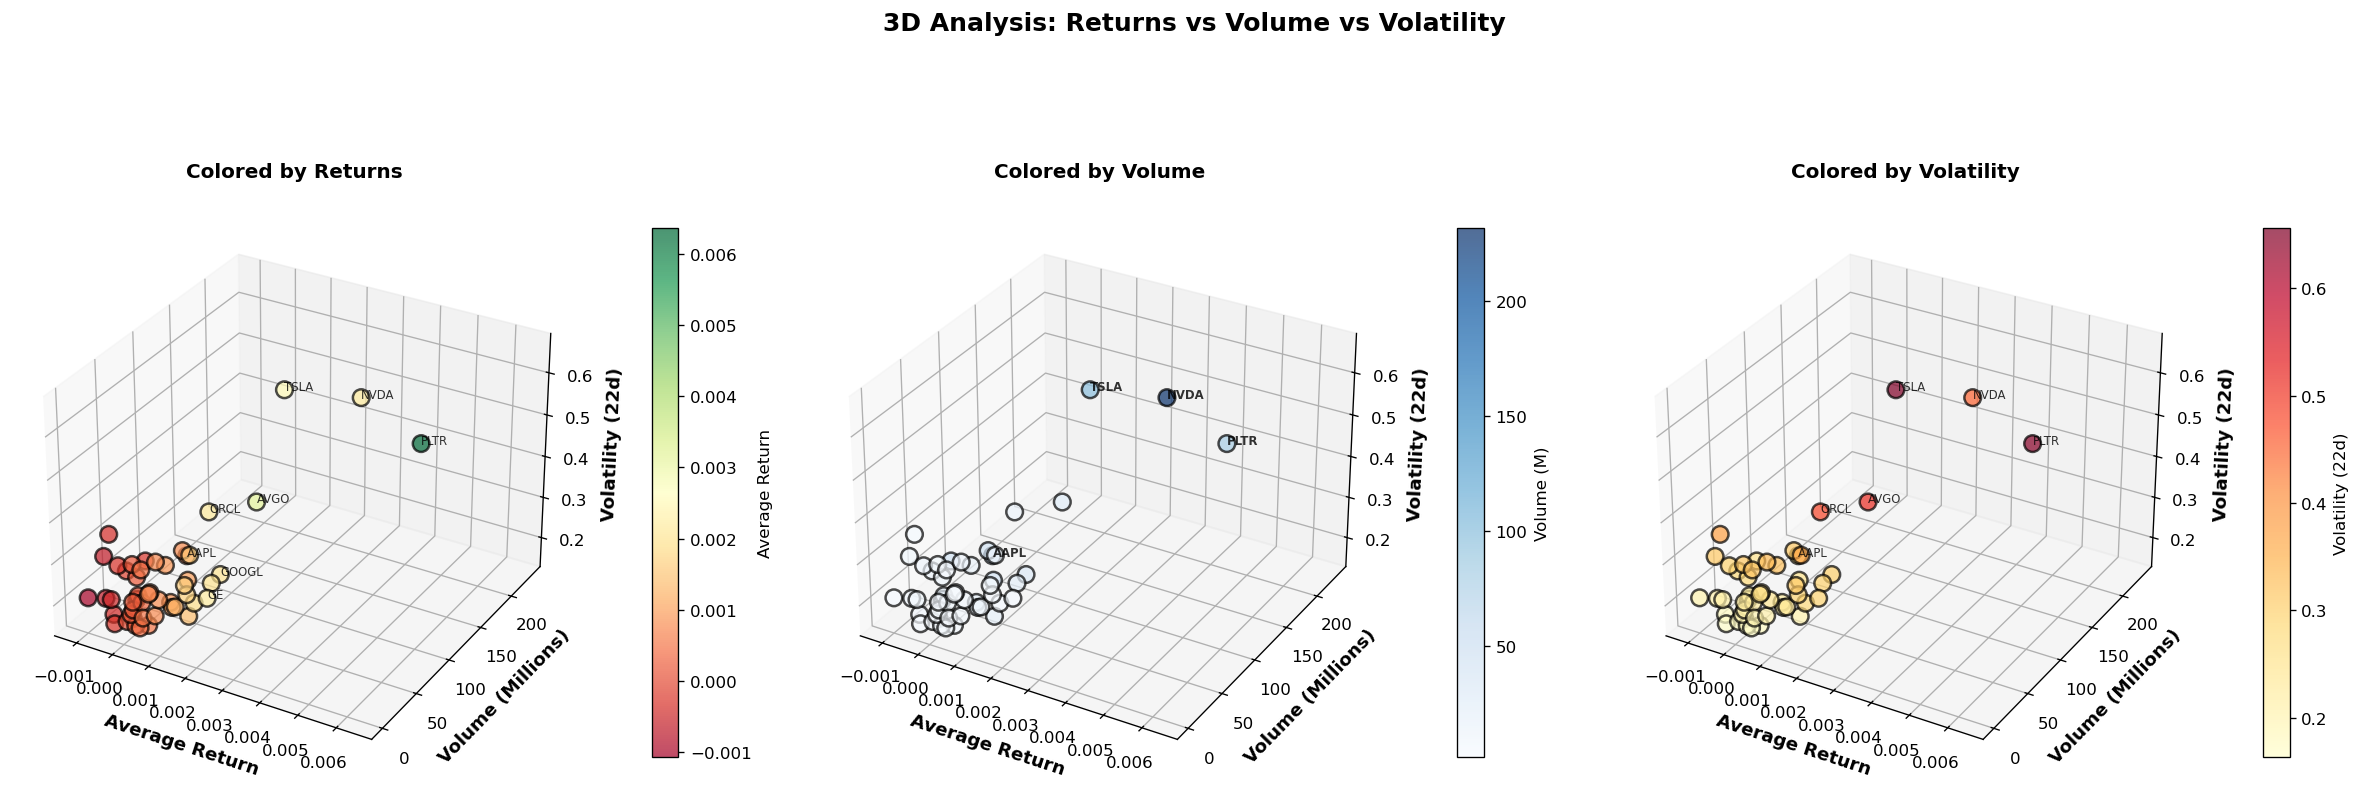

✓ Created 3D plot: Returns vs Volume vs Volatility
  - Plot saved as: plot_3d_returns_volume_volatility.png

--------------------------------------------------------------------------------
3D VISUALIZATION SUMMARY
--------------------------------------------------------------------------------
Total stocks analyzed: 50

Returns range: [-0.1078%, 0.6366%]
Volatility range: [16.31%, 65.59%]
Market Cap range: $47.50B - $3485.84B
Volume range: 1.32M - 231.85M shares

--- Notable Stocks in 3D Space ---

Highest Return: PLTR (0.6366%)
Lowest Return: CL (-0.1078%)
Highest Volatility: TSLA (65.59%)
Lowest Volatility: KO (16.31%)
Largest Market Cap: NVDA ($3485.84B)
Highest Volume: NVDA (231.85M shares)



In [25]:
# =============================================================================
# PART 2: PRINCIPAL COMPONENT ANALYSIS (PCA)
# =============================================================================

print("\n" + "=" * 80)
print("PART 2: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("=" * 80 + "\n")

## 2.1 Standardization
print("-" * 80)
print("STEP 2.1: DATA STANDARDIZATION")
print("-" * 80 + "\n")

print("Why Standardization?")
print("  PCA is sensitive to the scale of features. Features with larger")
print("  magnitudes (e.g., market cap in billions) would dominate the analysis.")
print("  Standardization ensures all features contribute equally.\n")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform
X_scaled = scaler.fit_transform(X_features)

# Convert back to DataFrame for easier handling
X_scaled_df = pd.DataFrame(
    X_scaled,
    index=X_features.index,
    columns=X_features.columns
)

print("Original Data (first 5 stocks):")
print(X_features.head().to_string())

print("\n\nStandardized Data (first 5 stocks):")
print(X_scaled_df.head().to_string())

print("\n\nStandardized Data Statistics:")
print("Mean (should be ~0):")
print(X_scaled_df.mean().to_string())
print("\nStd Dev (should be ~1):")
print(X_scaled_df.std().to_string())

## 2.2 Apply PCA
print("\n" + "-" * 80)
print("STEP 2.2: APPLYING PCA")
print("-" * 80 + "\n")

# Fit PCA with all components first to see variance explained
pca_full = PCA()
pca_full.fit(X_scaled)

# Get explained variance
explained_variance = pca_full.explained_variance_
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Create summary DataFrame
pca_summary = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Eigenvalue': explained_variance,
    'Variance Explained (%)': explained_variance_ratio * 100,
    'Cumulative Variance (%)': cumulative_variance_ratio * 100
})

print("PCA Variance Analysis:")
print("=" * 80)
print(pca_summary.to_string(index=False))
print("=" * 80)

## 2.3 Scree Plot (Elbow Method for PCA)
print("\n" + "-" * 80)
print("STEP 2.3: SCREE PLOT - DETERMINING OPTIMAL NUMBER OF COMPONENTS")
print("-" * 80 + "\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Explained Variance
axes[0].plot(range(1, len(explained_variance_ratio) + 1), 
             explained_variance_ratio * 100, 
             'bo-', linewidth=2, markersize=8)
axes[0].axhline(y=10, color='r', linestyle='--', label='10% threshold')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Variance Explained (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Scree Plot: Variance Explained by Each PC', 
                   fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()
axes[0].set_xticks(range(1, len(explained_variance_ratio) + 1))

# Plot 2: Cumulative Variance
axes[1].plot(range(1, len(cumulative_variance_ratio) + 1), 
             cumulative_variance_ratio * 100, 
             'ro-', linewidth=2, markersize=8)
axes[1].axhline(y=80, color='g', linestyle='--', label='80% threshold')
axes[1].axhline(y=90, color='b', linestyle='--', label='90% threshold')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Variance Explained (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Variance Explained', 
                   fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
axes[1].set_xticks(range(1, len(cumulative_variance_ratio) + 1))

plt.tight_layout()
plt.savefig('pca_scree_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Scree Plot saved as 'pca_scree_plot.png'")

# Determine optimal number of components
# Rule 1: Eigenvalue > 1 (Kaiser criterion)
n_components_kaiser = np.sum(explained_variance > 1)

# Rule 2: Cumulative variance >= 80%
n_components_80 = np.argmax(cumulative_variance_ratio >= 0.80) + 1

# Rule 3: Cumulative variance >= 90%
n_components_90 = np.argmax(cumulative_variance_ratio >= 0.90) + 1

print(f"\nOptimal Number of Components (different criteria):")
print(f"  - Kaiser Criterion (Eigenvalue > 1): {n_components_kaiser} components")
print(f"  - 80% Variance Explained: {n_components_80} components")
print(f"  - 90% Variance Explained: {n_components_90} components")

# Choose n_components (using 80% threshold as standard)
n_components = n_components_80
print(f"\n✓ Selected {n_components} components (explains {cumulative_variance_ratio[n_components-1]*100:.2f}% of variance)")

## 2.4 Fit PCA with Optimal Number of Components
print("\n" + "-" * 80)
print(f"STEP 2.4: FITTING PCA WITH {n_components} COMPONENTS")
print("-" * 80 + "\n")

# Fit PCA with selected number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# Create DataFrame for PC scores
pc_columns = [f'PC{i+1}' for i in range(n_components)]
X_pca_df = pd.DataFrame(
    X_pca,
    index=X_features.index,
    columns=pc_columns
)

print("Principal Component Scores (first 10 stocks):")
print(X_pca_df.head(10).to_string())

print(f"\n\nPC Scores Shape: {X_pca_df.shape}")
print(f"Variance Explained: {pca.explained_variance_ratio_.sum()*100:.2f}%")

## 2.5 Interpret Principal Components via Loadings
print("\n" + "-" * 80)
print("STEP 2.5: INTERPRETING PRINCIPAL COMPONENTS")
print("-" * 80 + "\n")

# Get loadings (components_)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=pc_columns,
    index=X_features.columns
)

print("Factor Loadings Matrix:")
print("=" * 80)
print(loadings.to_string())
print("=" * 80)

# Visualize loadings as heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, fmt='.3f', cmap='RdBu_r', 
            center=0, cbar_kws={'label': 'Loading'})
plt.title('PCA Loadings: Feature Contributions to Principal Components', 
          fontsize=14, fontweight='bold')
plt.xlabel('Principal Component', fontsize=12, fontweight='bold')
plt.ylabel('Original Feature', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('pca_loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nLoadings heatmap saved as 'pca_loadings_heatmap.png'")

# Interpret each component
print("\n" + "-" * 80)
print("INTERPRETATION OF PRINCIPAL COMPONENTS:")
print("-" * 80)

for i in range(n_components):
    pc_name = f'PC{i+1}'
    print(f"\n{pc_name} (explains {pca.explained_variance_ratio_[i]*100:.2f}% of variance):")
    
    # Get top 3 positive and negative loadings
    pc_loadings = loadings[pc_name].sort_values(ascending=False)
    
    print("  Highest positive loadings:")
    for feature, loading in pc_loadings.head(3).items():
        print(f"    {feature:25s}: {loading:+.3f}")
    
    print("  Highest negative loadings:")
    for feature, loading in pc_loadings.tail(3).items():
        print(f"    {feature:25s}: {loading:+.3f}")
    
    # Economic interpretation
    if i == 0:
        print("  → Interpretation: Likely represents 'Risk/Volatility Factor'")
        print("    (volatility measures vs returns)")
    elif i == 1:
        print("  → Interpretation: Likely represents 'Market Size/Scale Factor' ")
        print("     (combination of market cap, volume, and fundamental strength)")
    elif i == 2:
        print("  → Interpretation: Likely represents 'Risk-Return Trade-off'")
        print("     (balance between returns and volatility)")

## 2.6 Visualize Stocks in PC Space (2D and 3D)
print("\n" + "-" * 80)
print("STEP 2.6: VISUALIZING STOCKS IN PRINCIPAL COMPONENT SPACE")
print("-" * 80 + "\n")

# 2D Plot: PC1 vs PC2
fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(X_pca_df['PC1'], X_pca_df['PC2'], 
                     s=100, alpha=0.6, edgecolors='black', linewidth=1.5)

# Add stock labels
for idx, ticker in enumerate(X_pca_df.index):
    ax.annotate(ticker, (X_pca_df['PC1'].iloc[idx], X_pca_df['PC2'].iloc[idx]),
                fontsize=8, ha='center', va='bottom')

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontsize=12, fontweight='bold')
ax.set_title('Stock Positions in PC1-PC2 Space', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='k', linewidth=0.5)
ax.axvline(x=0, color='k', linewidth=0.5)

plt.tight_layout()
plt.savefig('pca_2d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("2D scatter plot saved as 'pca_2d_scatter.png'")

# 3D Plot: PC1 vs PC2 vs PC3 (if we have at least 3 components)
if n_components >= 3:
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    scatter = ax.scatter(X_pca_df['PC1'], X_pca_df['PC2'], X_pca_df['PC3'],
                        s=100, alpha=0.6, edgecolors='black', linewidth=1.5)
    
    # Add labels
    for idx, ticker in enumerate(X_pca_df.index):
        ax.text(X_pca_df['PC1'].iloc[idx], 
                X_pca_df['PC2'].iloc[idx],
                X_pca_df['PC3'].iloc[idx],
                ticker, fontsize=7)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', 
                  fontsize=11, fontweight='bold')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', 
                  fontsize=11, fontweight='bold')
    ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', 
                  fontsize=11, fontweight='bold')
    ax.set_title('Stock Positions in 3D PC Space', 
                 fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('pca_3d_scatter.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("3D scatter plot saved as 'pca_3d_scatter.png'")

# =============================================================================
# PART 2.7: ADVANCED 3D FEATURE VISUALIZATION
# =============================================================================

print("\n" + "=" * 80)
print("PART 2.7: ADVANCED 3D FEATURE VISUALIZATION")
print("=" * 80 + "\n")

print("-" * 80)
print("CREATING 3D SCATTER PLOTS WITH ORIGINAL FEATURES")
print("-" * 80 + "\n")

## 3D Plot 1: Returns vs Volatility vs Market Cap
print("--- 3D Plot 1: Returns vs Volatility (22d) vs Market Cap ---")

# Extract data for plotting
x_returns = X_features['avg_return'].values
y_volatility = X_features['avg_volatility_22d'].values
z_market_cap = X_features['avg_market_cap'].values / 1e9  # Convert to billions

# Normalize for better color visualization
from matplotlib.colors import Normalize
norm = Normalize(vmin=x_returns.min(), vmax=x_returns.max())

# Create figure with 3 subplots
fig = plt.figure(figsize=(20, 8))

# Plot 1: Colored by Returns
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(x_returns, y_volatility, z_market_cap,
                      c=x_returns, cmap='RdYlGn',
                      s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax1.set_xlabel('Average Return', fontsize=11, fontweight='bold')
ax1.set_ylabel('Volatility (22d)', fontsize=11, fontweight='bold')
ax1.set_zlabel('Market Cap ($B)', fontsize=11, fontweight='bold')
ax1.set_title('Colored by Returns', fontsize=12, fontweight='bold', pad=20)
plt.colorbar(scatter1, ax=ax1, label='Average Return', shrink=0.6, pad=0.1)

# Add stock labels for notable points
for idx, ticker in enumerate(X_features.index):
    if z_market_cap[idx] > 2000 or abs(x_returns[idx]) > 0.002:  # Label large caps or extreme returns
        ax1.text(x_returns[idx], y_volatility[idx], z_market_cap[idx],
                ticker, fontsize=7, alpha=0.8)

# Plot 2: Colored by Volatility
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(x_returns, y_volatility, z_market_cap,
                      c=y_volatility, cmap='YlOrRd',
                      s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax2.set_xlabel('Average Return', fontsize=11, fontweight='bold')
ax2.set_ylabel('Volatility (22d)', fontsize=11, fontweight='bold')
ax2.set_zlabel('Market Cap ($B)', fontsize=11, fontweight='bold')
ax2.set_title('Colored by Volatility', fontsize=12, fontweight='bold', pad=20)
plt.colorbar(scatter2, ax=ax2, label='Volatility (22d)', shrink=0.6, pad=0.1)

# Add stock labels
for idx, ticker in enumerate(X_features.index):
    if z_market_cap[idx] > 2000 or y_volatility[idx] > 0.4:  # Label large caps or high volatility
        ax2.text(x_returns[idx], y_volatility[idx], z_market_cap[idx],
                ticker, fontsize=7, alpha=0.8)

# Plot 3: Colored by Market Cap
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(x_returns, y_volatility, z_market_cap,
                      c=z_market_cap, cmap='viridis',
                      s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax3.set_xlabel('Average Return', fontsize=11, fontweight='bold')
ax3.set_ylabel('Volatility (22d)', fontsize=11, fontweight='bold')
ax3.set_zlabel('Market Cap ($B)', fontsize=11, fontweight='bold')
ax3.set_title('Colored by Market Cap', fontsize=12, fontweight='bold', pad=20)
plt.colorbar(scatter3, ax=ax3, label='Market Cap ($B)', shrink=0.6, pad=0.1)

# Add stock labels for mega caps
for idx, ticker in enumerate(X_features.index):
    if z_market_cap[idx] > 2000:  # Label mega caps only
        ax3.text(x_returns[idx], y_volatility[idx], z_market_cap[idx],
                ticker, fontsize=7, alpha=0.8, fontweight='bold')

plt.suptitle('3D Analysis: Returns vs Volatility vs Market Cap',
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('plot_3d_returns_volatility_marketcap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Created 3D plot: Returns vs Volatility vs Market Cap")
print(f"  - Plot saved as: plot_3d_returns_volatility_marketcap.png")

## 3D Plot 2: Returns vs Volume vs Volatility
print("\n--- 3D Plot 2: Returns vs Volume vs Volatility (22d) ---")

# Extract data for plotting
x_returns2 = X_features['avg_return'].values
y_volume = X_features['avg_volume'].values / 1e6  # Convert to millions
z_volatility2 = X_features['avg_volatility_22d'].values

# Create figure with 3 subplots
fig = plt.figure(figsize=(20, 8))

# Plot 1: Colored by Returns
ax1 = fig.add_subplot(131, projection='3d')
scatter1 = ax1.scatter(x_returns2, y_volume, z_volatility2,
                      c=x_returns2, cmap='RdYlGn',
                      s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax1.set_xlabel('Average Return', fontsize=11, fontweight='bold')
ax1.set_ylabel('Volume (Millions)', fontsize=11, fontweight='bold')
ax1.set_zlabel('Volatility (22d)', fontsize=11, fontweight='bold')
ax1.set_title('Colored by Returns', fontsize=12, fontweight='bold', pad=20)
plt.colorbar(scatter1, ax=ax1, label='Average Return', shrink=0.6, pad=0.1)

# Add stock labels for extreme returns or high volume
for idx, ticker in enumerate(X_features.index):
    if abs(x_returns2[idx]) > 0.002 or y_volume[idx] > 50:
        ax1.text(x_returns2[idx], y_volume[idx], z_volatility2[idx],
                ticker, fontsize=7, alpha=0.8)

# Plot 2: Colored by Volume
ax2 = fig.add_subplot(132, projection='3d')
scatter2 = ax2.scatter(x_returns2, y_volume, z_volatility2,
                      c=y_volume, cmap='Blues',
                      s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax2.set_xlabel('Average Return', fontsize=11, fontweight='bold')
ax2.set_ylabel('Volume (Millions)', fontsize=11, fontweight='bold')
ax2.set_zlabel('Volatility (22d)', fontsize=11, fontweight='bold')
ax2.set_title('Colored by Volume', fontsize=12, fontweight='bold', pad=20)
plt.colorbar(scatter2, ax=ax2, label='Volume (M)', shrink=0.6, pad=0.1)

# Add stock labels for high volume stocks
for idx, ticker in enumerate(X_features.index):
    if y_volume[idx] > 50:
        ax2.text(x_returns2[idx], y_volume[idx], z_volatility2[idx],
                ticker, fontsize=7, alpha=0.8, fontweight='bold')

# Plot 3: Colored by Volatility
ax3 = fig.add_subplot(133, projection='3d')
scatter3 = ax3.scatter(x_returns2, y_volume, z_volatility2,
                      c=z_volatility2, cmap='YlOrRd',
                      s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax3.set_xlabel('Average Return', fontsize=11, fontweight='bold')
ax3.set_ylabel('Volume (Millions)', fontsize=11, fontweight='bold')
ax3.set_zlabel('Volatility (22d)', fontsize=11, fontweight='bold')
ax3.set_title('Colored by Volatility', fontsize=12, fontweight='bold', pad=20)
plt.colorbar(scatter3, ax=ax3, label='Volatility (22d)', shrink=0.6, pad=0.1)

# Add stock labels for high volatility stocks
for idx, ticker in enumerate(X_features.index):
    if z_volatility2[idx] > 0.4 or y_volume[idx] > 50:
        ax3.text(x_returns2[idx], y_volume[idx], z_volatility2[idx],
                ticker, fontsize=7, alpha=0.8)

plt.suptitle('3D Analysis: Returns vs Volume vs Volatility',
             fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('plot_3d_returns_volume_volatility.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Created 3D plot: Returns vs Volume vs Volatility")
print(f"  - Plot saved as: plot_3d_returns_volume_volatility.png")

# Summary statistics for 3D plots
print("\n" + "-" * 80)
print("3D VISUALIZATION SUMMARY")
print("-" * 80)
print(f"Total stocks analyzed: {len(X_features)}")
print(f"\nReturns range: [{x_returns.min():.4%}, {x_returns.max():.4%}]")
print(f"Volatility range: [{y_volatility.min():.2%}, {y_volatility.max():.2%}]")
print(f"Market Cap range: ${z_market_cap.min():.2f}B - ${z_market_cap.max():.2f}B")
print(f"Volume range: {y_volume.min():.2f}M - {y_volume.max():.2f}M shares")

# Find and display interesting stocks
print(f"\n--- Notable Stocks in 3D Space ---")
print(f"\nHighest Return: {X_features.index[np.argmax(x_returns)]} ({x_returns.max():.4%})")
print(f"Lowest Return: {X_features.index[np.argmin(x_returns)]} ({x_returns.min():.4%})")
print(f"Highest Volatility: {X_features.index[np.argmax(y_volatility)]} ({y_volatility.max():.2%})")
print(f"Lowest Volatility: {X_features.index[np.argmin(y_volatility)]} ({y_volatility.min():.2%})")
print(f"Largest Market Cap: {X_features.index[np.argmax(z_market_cap)]} (${z_market_cap.max():.2f}B)")
print(f"Highest Volume: {X_features.index[np.argmax(y_volume)]} ({y_volume.max():.2f}M shares)")

print("\n" + "=" * 80)

<h3 style="color:#004488; font-weight:700; margin-top:12px;">
Task 3 — Principal Component Analysis (PCA)
</h3>

<p style="font-size:16px; line-height:1.45;">
To reduce dimensionality and uncover latent structure in the cross-section of stocks, we applied Principal Component Analysis (PCA) to the standardized 6-factor feature matrix. Standardization ensures that features measured on different scales (e.g., price volatility vs. market capitalization) contribute equally to the variance structure.
</p>

<h4 style="color:#004488; font-weight:600; margin-top:12px;">Explained Variance</h4>

<table style="font-size:16px; border-collapse: collapse; width:65%; margin-top:6px;">
  <thead>
    <tr style="border-bottom: 2px solid #004488; background-color:#E8F4FA;">
      <th style="text-align:left; padding:8px;">Principal Component</th>
      <th style="text-align:right; padding:8px;">Variance Explained (%)</th>
      <th style="text-align:right; padding:8px;">Cumulative Variance (%)</th>
    </tr>
  </thead>
  <tbody>
    <tr><td style="padding:8px;">PC1</td><td style="padding:8px; text-align:right;">68.27%</td><td style="padding:8px; text-align:right;">68.27%</td></tr>
    <tr style="background-color:#F5F5F7;">
      <td style="padding:8px;">PC2</td><td style="padding:8px; text-align:right;">20.03%</td><td style="padding:8px; text-align:right;">88.30%</td>
    </tr>
    <tr>
      <td style="padding:8px;">PC3</td><td style="padding:8px; text-align:right;">6.67%</td><td style="padding:8px; text-align:right;">94.97%</td></tr>
  </tbody>
</table>

<p style="font-size:16px; line-height:1.45; margin-top:10px;">
<b>Model Selection:</b> We retain <b>2 principal components</b>, explaining <b>88.30%</b> of the total variance — a strong reduction that preserves most of the market structure.
</p>

<h4 style="color:#004488; font-weight:600; margin-top:14px;">Interpretation of PCA Factors</h4>

<p style="font-size:16px; line-height:1.45;">
<b>PC1 — Volatility / Risk Exposure</b><br>
PC1 loads heavily on 5-day, 10-day, and 22-day volatility metrics (~0.477).  
High PC1 scores identify <b>high-volatility, growth-oriented, speculative names</b>.  
Low PC1 scores indicate <b>stable, low-risk defensive stocks</b>.
</p>

<p style="font-size:16px; line-height:1.45;">
<b>PC2 — Market Scale / Liquidity Factor</b><br>
PC2 loads strongly on <b>Market Capitalization</b> (+0.777) and <b>Trading Volume</b> (+0.515).  
This factor separates <b>mega-cap, highly liquid institutional stocks</b> from <b>smaller or thinner-traded equities</b>.
</p>

<h4 style="color:#004488; font-weight:600; margin-top:18px;">
Notable Stock Positions (from PCA & 3D Visualizations)
</h4>

<table style="font-size:16px; border-collapse: collapse; width:100%; margin-top:6px;">
  <thead>
    <tr style="border-bottom: 2px solid #004488; background-color:#E8F4FA;">
      <th style="padding:8px; text-align:left;">Ticker</th>
      <th style="padding:8px; text-align:left;">Observation</th>
    </tr>
  </thead>
  <tbody>
    <tr><td style="padding:8px;">PLTR</td><td style="padding:8px;">Highest average return (≈ 0.64%)</td></tr>
    <tr style="background-color:#F5F5F7;"><td style="padding:8px;">TSLA</td><td style="padding:8px;">Highest volatility (≈ 65.59%)</td></tr>
    <tr><td style="padding:8px;">KO</td><td style="padding:8px;">Lowest volatility (~16.31%), stable defensive</td></tr>
    <tr style="background-color:#F5F5F7;"><td style="padding:8px;">NVDA</td><td style="padding:8px;">Largest market cap and highest daily volume</td></tr>
  </tbody>
</table>

<h4 style="color:#004488; font-weight:600; margin-top:18px;">3D Visualization Summary</h4>

<p style="font-size:16px; line-height:1.45;">
The 3D scatter plots reinforce a clear structural pattern:
</p>

<ul style="font-size:16px; line-height:1.45;">
  <li><b>High-risk, growth cluster:</b> TSLA, PLTR, NVDA (high volatility + high volume)</li>
  <li><b>Stable defensive cluster:</b> KO, PG, JNJ (low-volatility consumer/healthcare)</li>
  <li><b>Mega-cap leadership cluster:</b> AAPL, AMZN, MSFT, NVDA (scale + market dominance)</li>
</ul>

<p style="font-size:16px; margin-top:10px;">
<b>Conclusion:</b> PCA reveals two dominant forces driving cross-sectional equity behavior:
<br> (1) <b>Risk / Volatility Intensity</b> and (2) <b>Market Size & Liquidity Scale</b>.
</p>



PART 3: K-MEANS CLUSTERING

--------------------------------------------------------------------------------
STEP 3.1: ELBOW METHOD - FINDING OPTIMAL K
--------------------------------------------------------------------------------

Testing K from 2 to 10...

K= 2: Inertia=113.03 | Silhouette=0.710 | Davies-Bouldin=0.635
K= 3: Inertia=79.74 | Silhouette=0.649 | Davies-Bouldin=0.724
K= 4: Inertia=51.92 | Silhouette=0.483 | Davies-Bouldin=0.697
K= 5: Inertia=30.55 | Silhouette=0.502 | Davies-Bouldin=0.513
K= 6: Inertia=19.01 | Silhouette=0.519 | Davies-Bouldin=0.449
K= 7: Inertia=13.17 | Silhouette=0.459 | Davies-Bouldin=0.518
K= 8: Inertia=9.93 | Silhouette=0.481 | Davies-Bouldin=0.466
K= 9: Inertia=8.19 | Silhouette=0.454 | Davies-Bouldin=0.516
K=10: Inertia=6.72 | Silhouette=0.440 | Davies-Bouldin=0.489


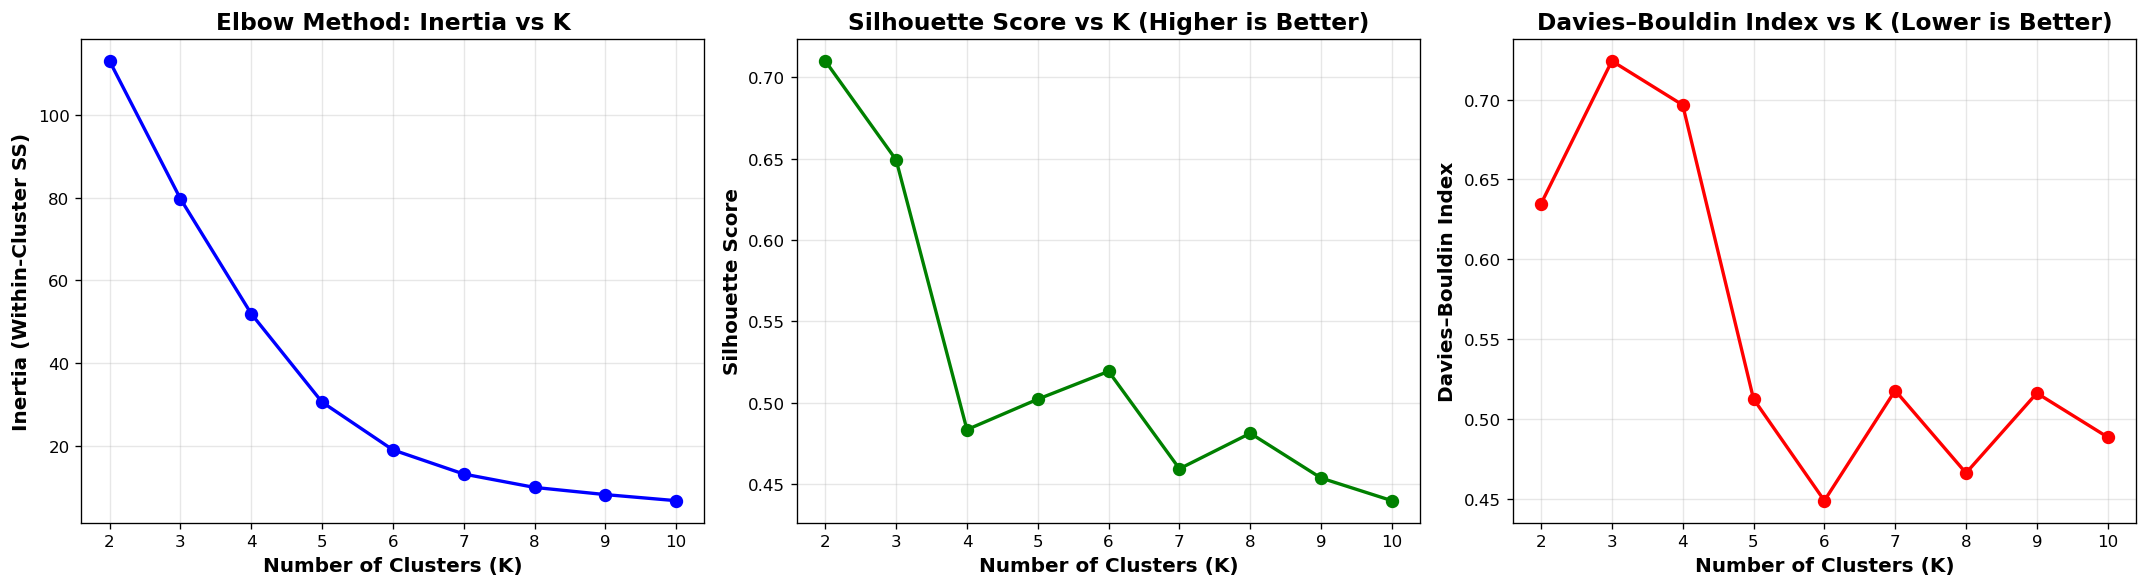


Elbow method plots saved as 'kmeans_elbow_method.png'

--------------------------------------------------------------------------------
OPTIMAL K SELECTION (metrics):
--------------------------------------------------------------------------------
  • Silhouette (max): K = 2
  • Davies–Bouldin (min): K = 6
  • Elbow (visual): K ≈ 4

✓ Using K = 4 (recommended) for final model

--------------------------------------------------------------------------------
STEP 3.2: FITTING K-MEANS WITH K=4
--------------------------------------------------------------------------------

Cluster Assignment:

Cluster 0 (19 stocks):
  ABBV, BA, BAC, BMY, CAT, COP, CRM, DE, GE, GOOG, GOOGL, GS, LLY, META, MPC, NEE, NEM, NFLX, SBUX

Cluster 1 (4 stocks):
  AVGO, ORCL, PLTR, TSLA

Cluster 2 (4 stocks):
  AAPL, AMZN, MSFT, NVDA

Cluster 3 (23 stocks):
  BRK-B, CL, COST, CSCO, CVX, DIS, DUK, HD, HON, JNJ, JPM, KO, LIN, MA, MCD, MDLZ, PEP, PFE, PG, V, VZ, WMT, XOM

Clustering Quality Metrics:
  • Silhouette S

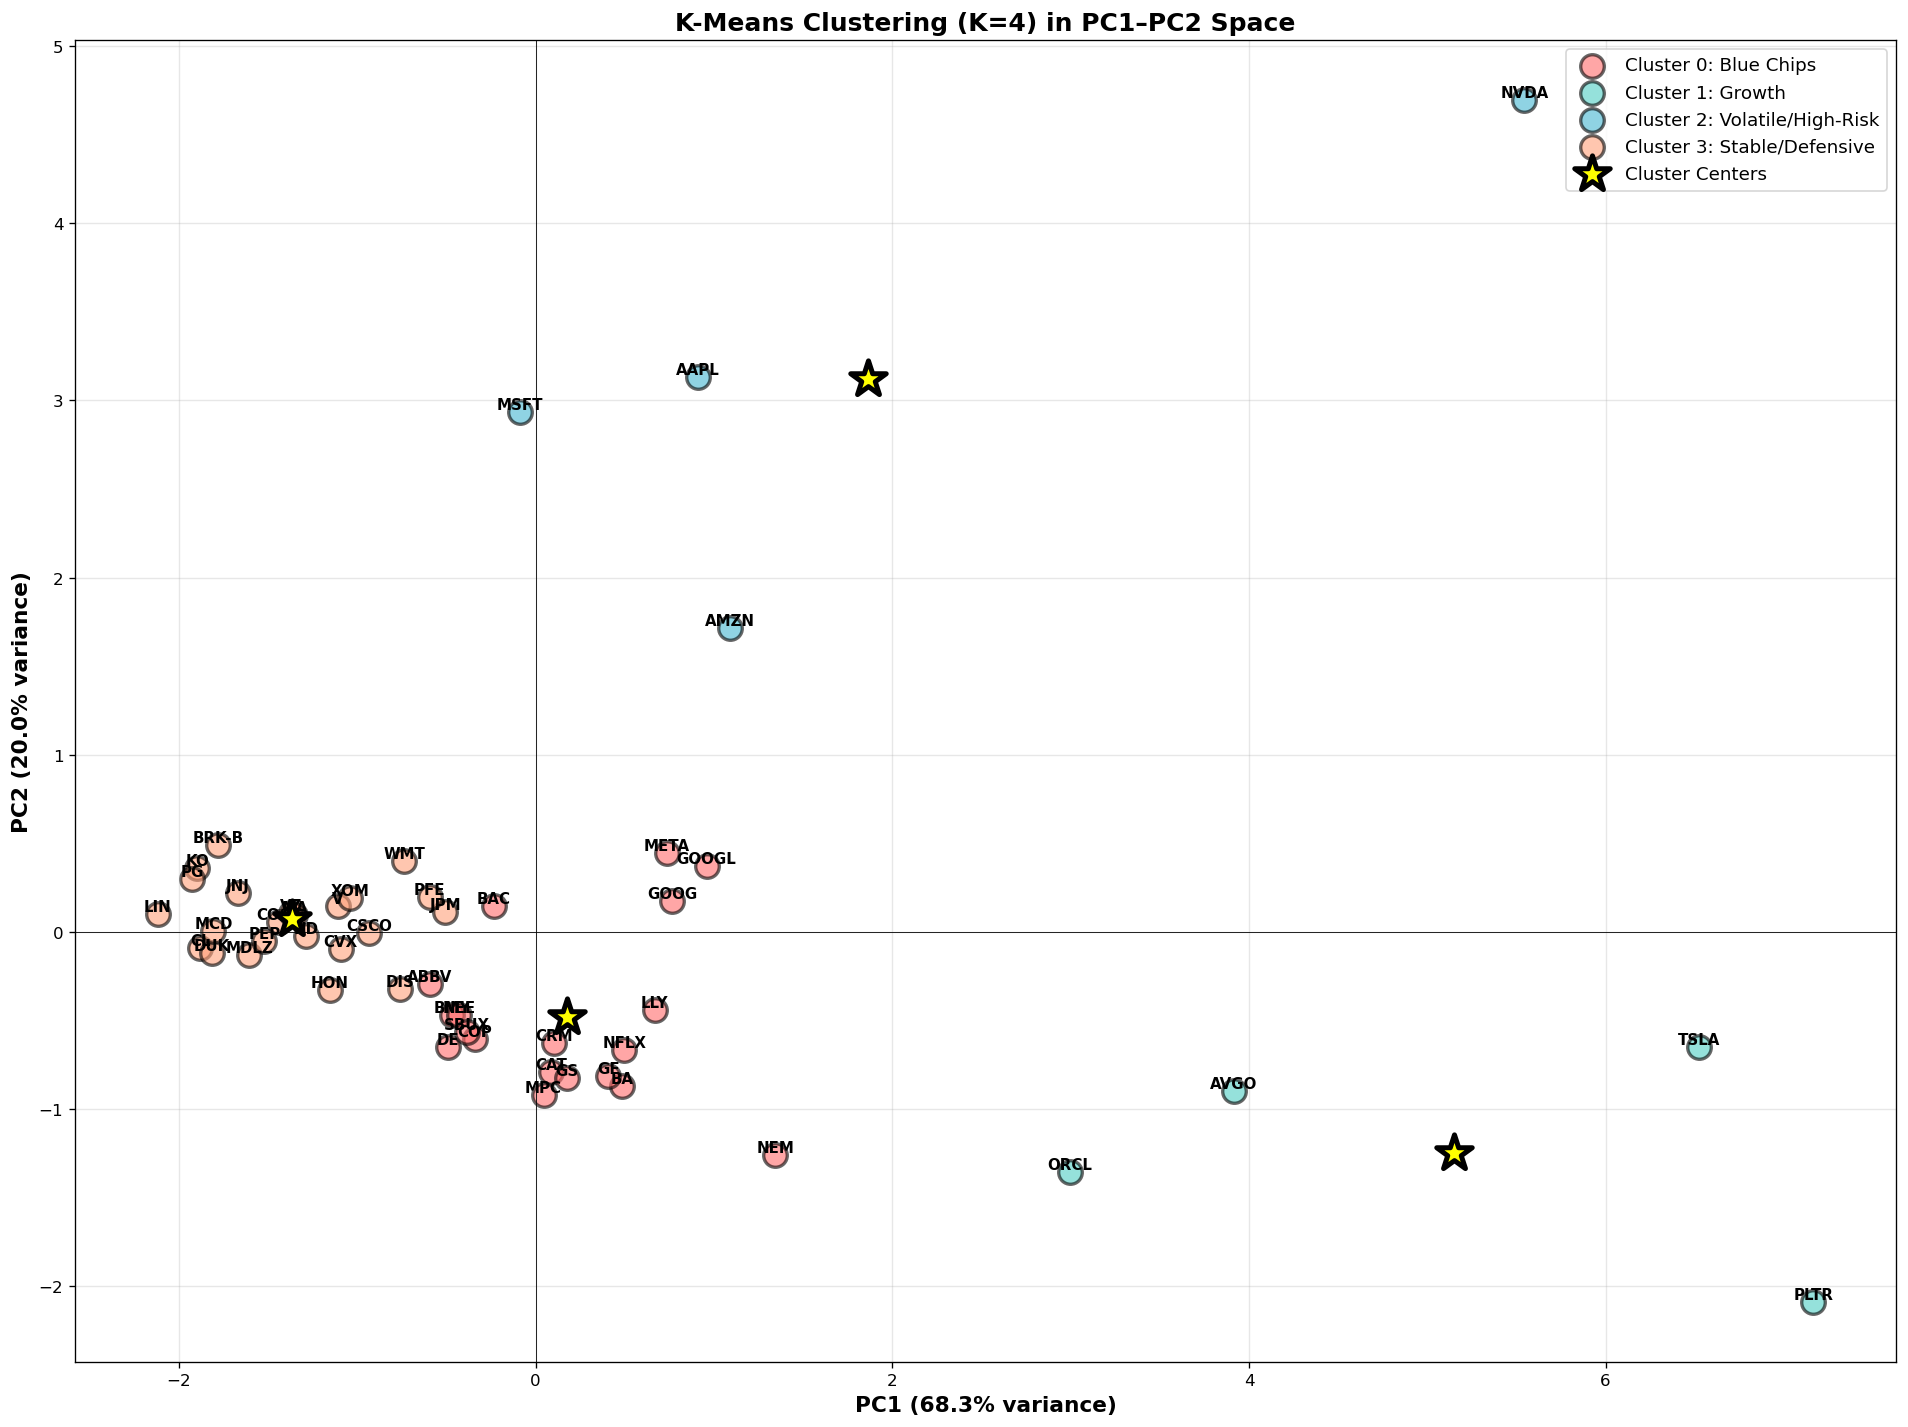

2D cluster visualization saved as 'kmeans_clusters_2d.png'

--------------------------------------------------------------------------------
STEP 3.4: CLUSTER CHARACTERISTICS (ORIGINAL FEATURES)
--------------------------------------------------------------------------------

Cluster Characteristics (Mean ± Std):
        avg_return              avg_volume               avg_market_cap               avg_volatility_5d           avg_volatility_10d           avg_volatility_22d          
              mean       std          mean           std           mean           std              mean       std               mean       std               mean       std
Cluster                                                                                                                                                                    
0         0.000868  0.000914  1.082295e+07  1.031984e+07   3.698312e+11  3.933607e+11          0.273694  0.030117           0.289000  0.032198           0.303214  0.0327

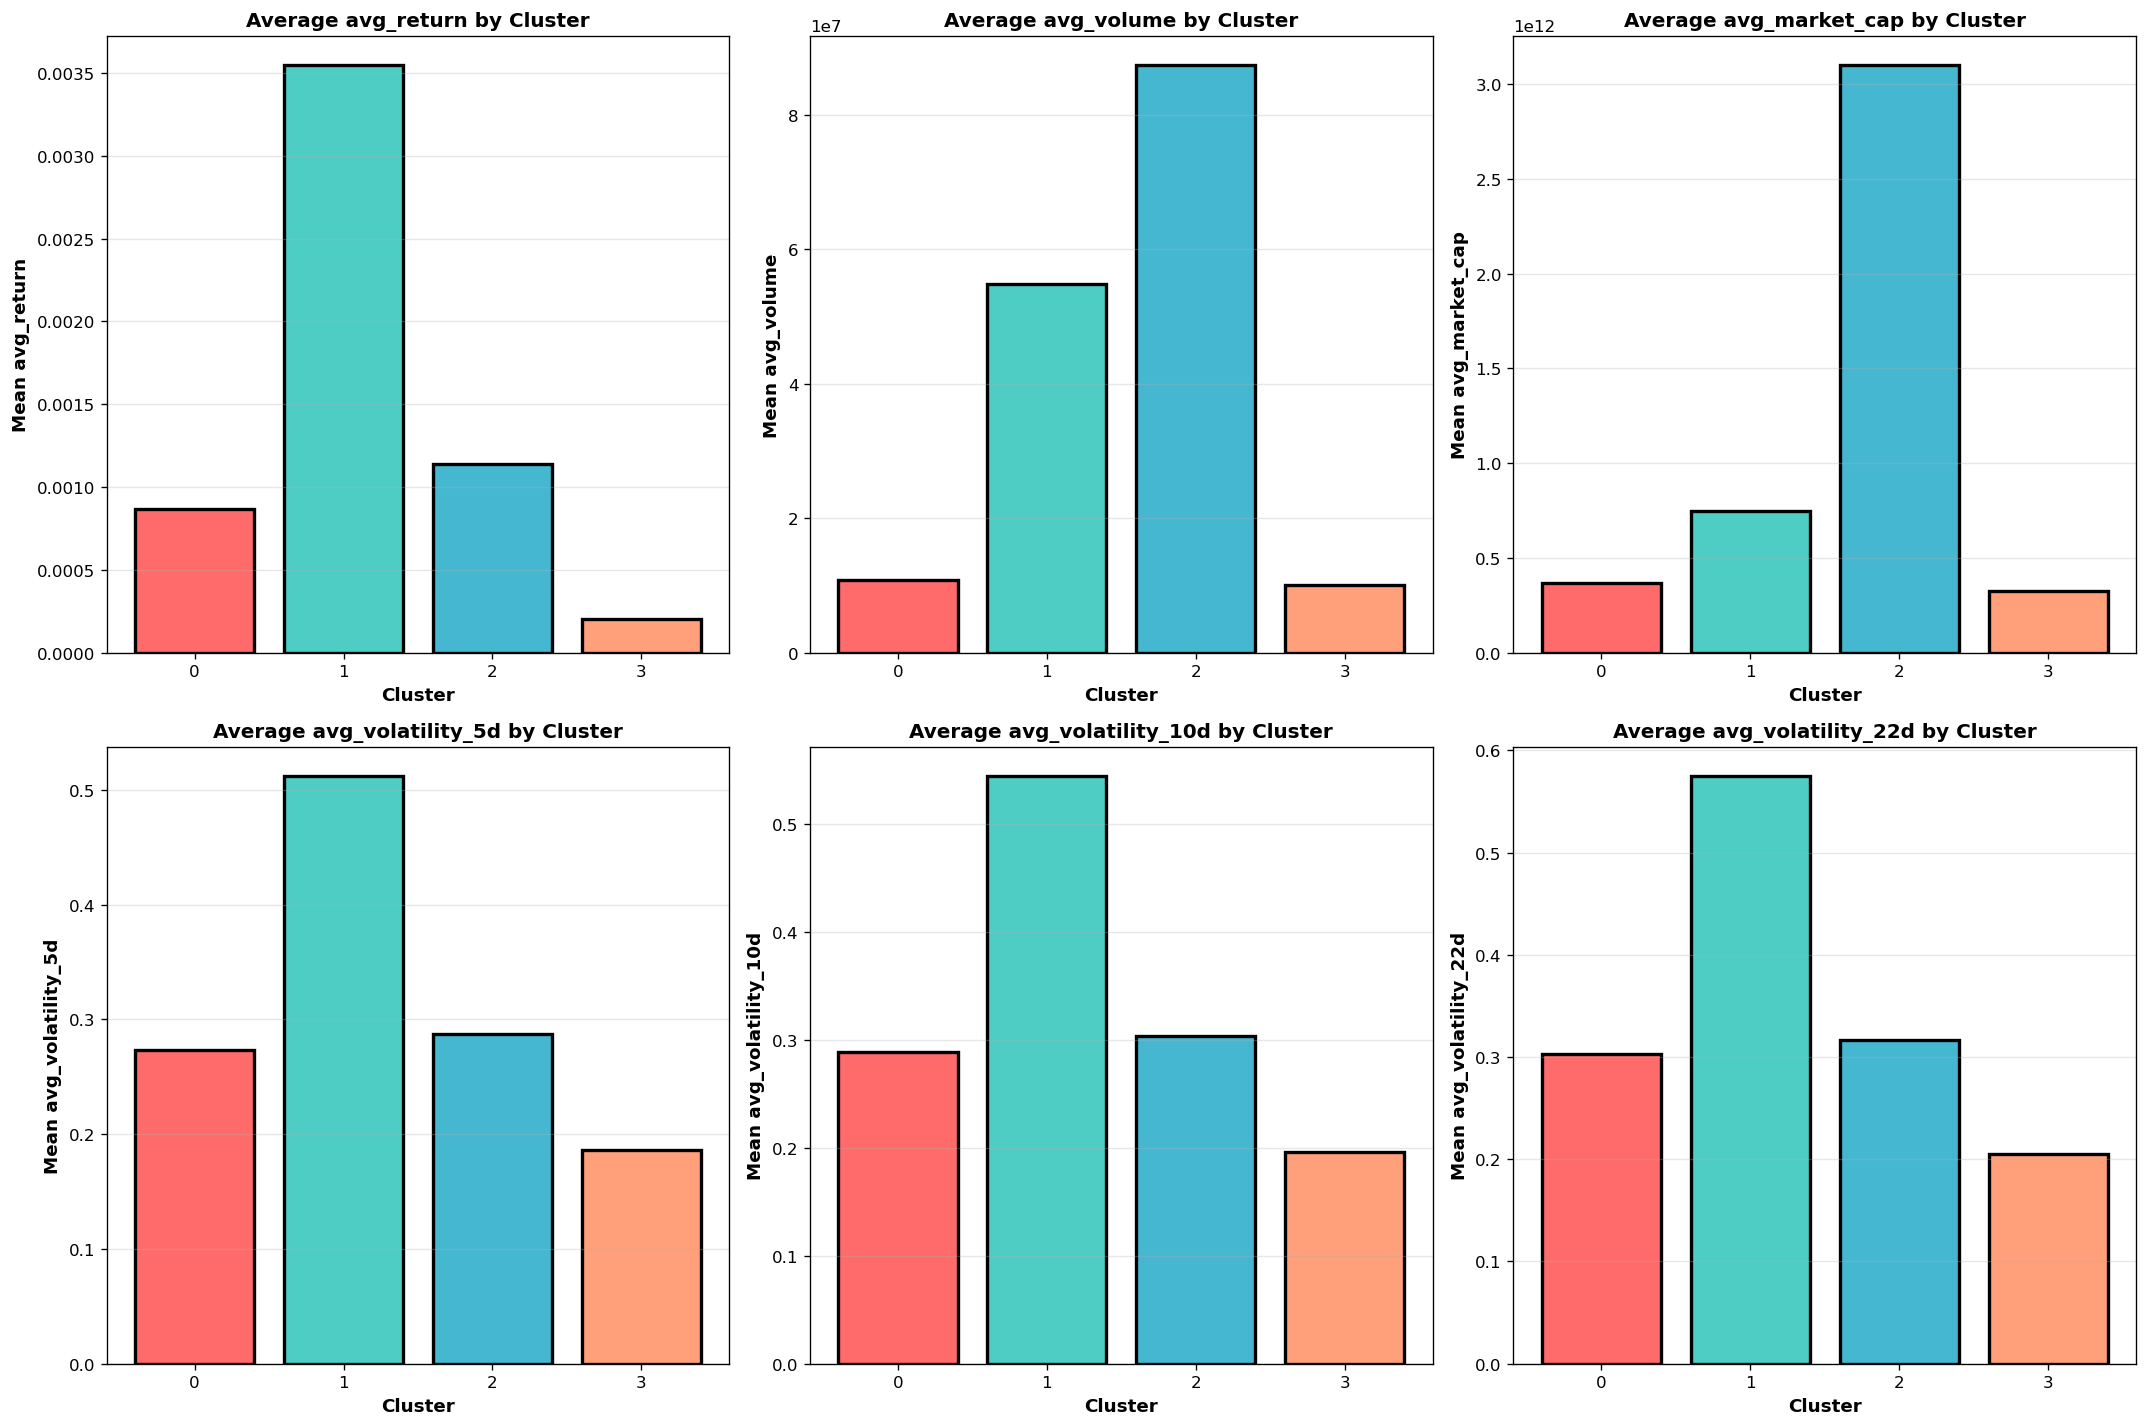

Cluster characteristics plot saved as 'cluster_characteristics.png'


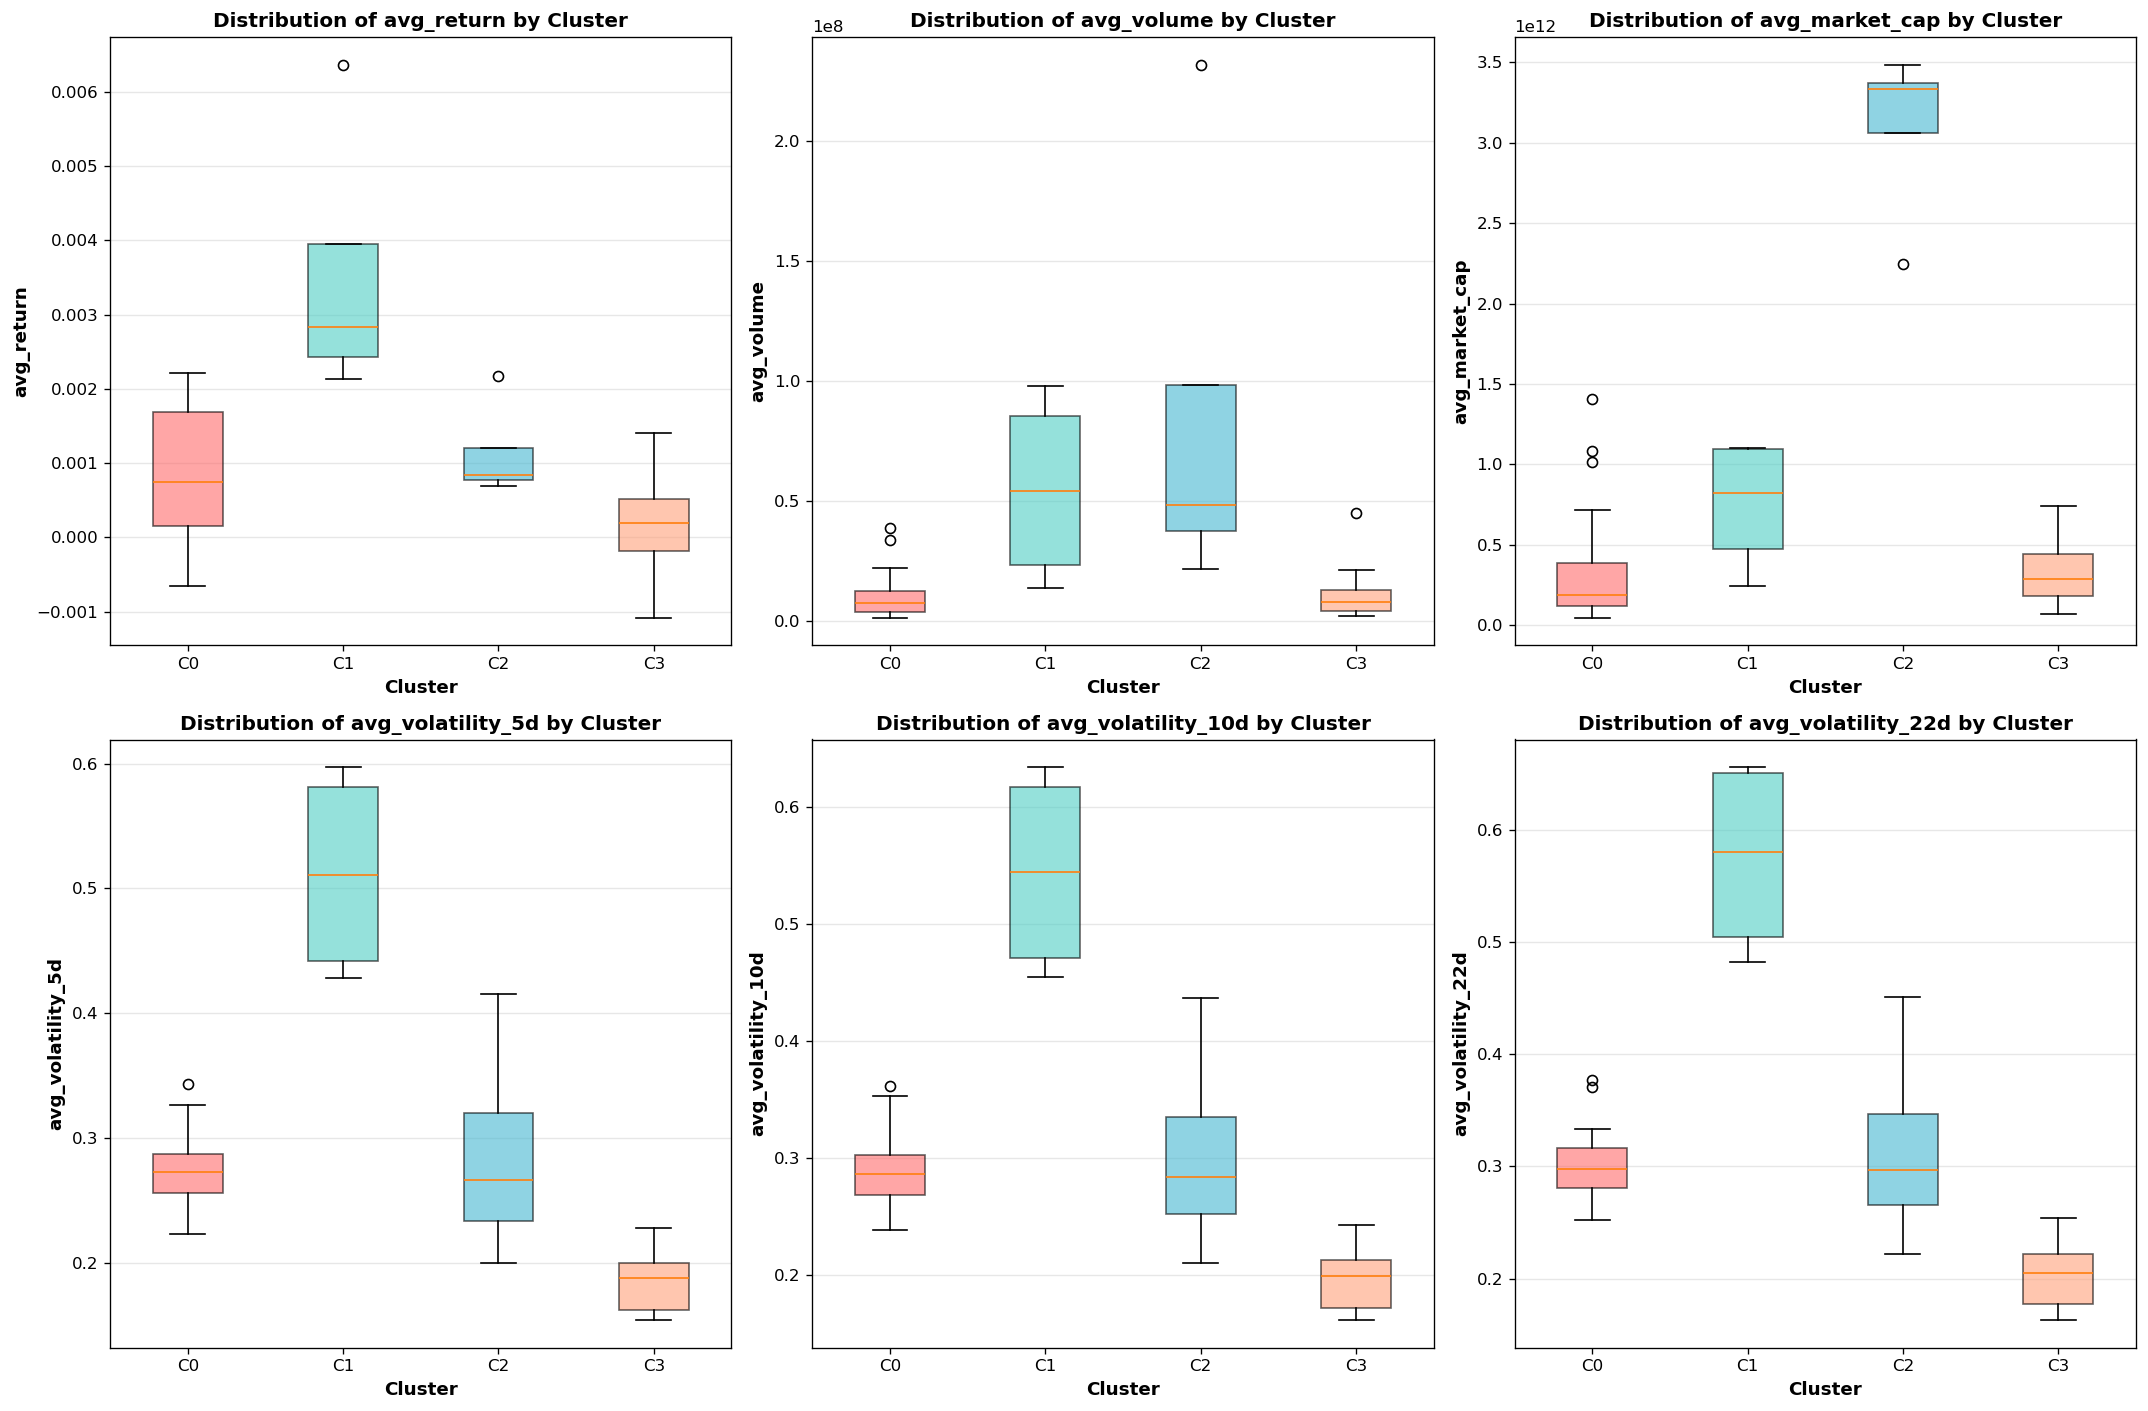

Cluster distributions plot saved as 'cluster_distributions.png'

--------------------------------------------------------------------------------
CLUSTER INTERPRETATION
--------------------------------------------------------------------------------


CLUSTER 0: Cluster 0: Blue Chips
Number of stocks: 19

Stocks: ABBV, BA, BAC, BMY, CAT, COP, CRM, DE, GE, GOOG, GOOGL, GS, LLY, META, MPC, NEE, NEM, NFLX, SBUX

Characteristics:
  Average Return          : 0.0868%
  Average Volume          : 10,822,952
  Average Market Cap      : $369.83B
  Average Volatility (22d): 30.32%

Top 5 stocks by market cap:
  META  : $1406.36B
  GOOGL : $1080.78B
  GOOG  : $1011.59B
  LLY   : $719.13B
  NFLX  : $431.81B

CLUSTER 1: Cluster 1: Growth
Number of stocks: 4

Stocks: AVGO, ORCL, PLTR, TSLA

Characteristics:
  Average Return          : 0.3546%
  Average Volume          : 54,844,194
  Average Market Cap      : $748.49B
  Average Volatility (22d): 57.46%

Top 5 stocks by market cap:
  AVGO  : $1103.77B


In [26]:
# =============================================================================
# PART 3: K-MEANS CLUSTERING
# =============================================================================
print("\n" + "=" * 80)
print("PART 3: K-MEANS CLUSTERING")
print("=" * 80 + "\n")

# ---------------------------------------------------------------------------
# 3.1 ELBOW / SILHOUETTE / DAVIES-BOULDIN
# ---------------------------------------------------------------------------
print("-" * 80)
print("STEP 3.1: ELBOW METHOD - FINDING OPTIMAL K")
print("-" * 80 + "\n")

K_range = range(2, 11)
inertias = []
silhouette_scores_list = []
davies_bouldin_scores_list = []

print("Testing K from 2 to 10...\n")
for k in K_range:
    km = KMeans(n_clusters=k, n_init=20, random_state=42, max_iter=300)
    labels_k = km.fit_predict(X_pca)
    inertias.append(km.inertia_)
    silhouette_scores_list.append(silhouette_score(X_pca, labels_k))
    davies_bouldin_scores_list.append(davies_bouldin_score(X_pca, labels_k))
    print(f"K={k:>2}: Inertia={km.inertia_:,.2f} | "
          f"Silhouette={silhouette_scores_list[-1]:.3f} | "
          f"Davies-Bouldin={davies_bouldin_scores_list[-1]:.3f}")

# Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(list(K_range), inertias, 'bo-', linewidth=2, markersize=7)
axes[0].set_title('Elbow Method: Inertia vs K', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia (Within-Cluster SS)', fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3); axes[0].set_xticks(list(K_range))

axes[1].plot(list(K_range), silhouette_scores_list, 'go-', linewidth=2, markersize=7)
axes[1].set_title('Silhouette Score vs K (Higher is Better)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3); axes[1].set_xticks(list(K_range))

axes[2].plot(list(K_range), davies_bouldin_scores_list, 'ro-', linewidth=2, markersize=7)
axes[2].set_title('Davies–Bouldin Index vs K (Lower is Better)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Davies–Bouldin Index', fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3); axes[2].set_xticks(list(K_range))

plt.tight_layout()
plt.savefig('kmeans_elbow_method.png', dpi=300, bbox_inches='tight')
plt.show()
print("\nElbow method plots saved as 'kmeans_elbow_method.png'")

# Data-driven suggestions
optimal_k_sil = list(K_range)[int(np.argmax(silhouette_scores_list))]
optimal_k_db  = list(K_range)[int(np.argmin(davies_bouldin_scores_list))]

print("\n" + "-" * 80)
print("OPTIMAL K SELECTION (metrics):")
print("-" * 80)
print(f"  • Silhouette (max): K = {optimal_k_sil}")
print(f"  • Davies–Bouldin (min): K = {optimal_k_db}")
print(f"  • Elbow (visual): K ≈ 4")
print("\n✓ Using K = 4 (recommended) for final model")

# ---------------------------------------------------------------------------
# 3.2 FIT FINAL K-MEANS (K=4)
# ---------------------------------------------------------------------------
optimal_k = 4
print("\n" + "-" * 80)
print(f"STEP 3.2: FITTING K-MEANS WITH K={optimal_k}")
print("-" * 80 + "\n")

kmeans_final = KMeans(n_clusters=optimal_k, n_init=20, random_state=42, max_iter=300)
cluster_labels = kmeans_final.fit_predict(X_pca)

# Attach labels
X_pca_df = X_pca_df.copy()
X_features = X_features.copy()
X_pca_df['Cluster'] = cluster_labels
X_features['Cluster'] = cluster_labels

# Print assignment
print("Cluster Assignment:")
print("=" * 80)
for cid in range(optimal_k):
    names = X_features[X_features['Cluster'] == cid].index.tolist()
    print(f"\nCluster {cid} ({len(names)} stocks):")
    print("  " + ", ".join(names))
print("=" * 80)

# Quality metrics on final K
final_silhouette = silhouette_score(X_pca, cluster_labels)
final_db = davies_bouldin_score(X_pca, cluster_labels)
print("\nClustering Quality Metrics:")
print(f"  • Silhouette Score: {final_silhouette:.3f}  (−1..+1, higher is better)")
print(f"  • Davies–Bouldin : {final_db:.3f}      (lower is better)")

# ---------------------------------------------------------------------------
# 3.3 VISUALIZE CLUSTERS IN PC SPACE (2D)
# ---------------------------------------------------------------------------
print("\n" + "-" * 80)
print("STEP 3.3: VISUALIZING CLUSTERS (2D)")
print("-" * 80 + "\n")

cluster_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
cluster_names  = ['Cluster 0: Blue Chips', 
                  'Cluster 1: Growth', 
                  'Cluster 2: Volatile/High-Risk', 
                  'Cluster 3: Stable/Defensive']

fig, ax = plt.subplots(figsize=(16, 12))
for cid in range(optimal_k):
    sub = X_pca_df[X_pca_df['Cluster'] == cid]
    ax.scatter(sub['PC1'], sub['PC2'], s=200, alpha=0.6,
               c=cluster_colors[cid], edgecolors='black', linewidth=2,
               label=cluster_names[cid])
    for i, tkr in enumerate(sub.index):
        ax.annotate(tkr, (sub['PC1'].iloc[i], sub['PC2'].iloc[i]),
                    fontsize=9, ha='center', va='bottom', fontweight='bold')

centers = kmeans_final.cluster_centers_
ax.scatter(centers[:, 0], centers[:, 1], s=500, c='yellow', marker='*',
           edgecolors='black', linewidth=3, label='Cluster Centers', zorder=5)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontsize=13, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontsize=13, fontweight='bold')
ax.set_title(f'K-Means Clustering (K={optimal_k}) in PC1–PC2 Space',
             fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='k', linewidth=0.5); ax.axvline(0, color='k', linewidth=0.5)

plt.tight_layout()
plt.savefig('kmeans_clusters_2d.png', dpi=300, bbox_inches='tight')
plt.show()
print("2D cluster visualization saved as 'kmeans_clusters_2d.png'")

# ---------------------------------------------------------------------------
# 3.4 CLUSTER STATS BACK IN ORIGINAL FEATURE SPACE
# ---------------------------------------------------------------------------
print("\n" + "-" * 80)
print("STEP 3.4: CLUSTER CHARACTERISTICS (ORIGINAL FEATURES)")
print("-" * 80 + "\n")

cluster_stats = X_features.groupby('Cluster').agg({
    'avg_return': ['mean', 'std'],
    'avg_volume': ['mean', 'std'],
    'avg_market_cap': ['mean', 'std'],
    'avg_volatility_5d': ['mean', 'std'],
    'avg_volatility_10d': ['mean', 'std'],
    'avg_volatility_22d': ['mean', 'std']
})
print("Cluster Characteristics (Mean ± Std):")
print("=" * 80)
print(cluster_stats.to_string())
print("=" * 80)

# Barplots of means
fig, axes = plt.subplots(2, 3, figsize=(18, 12)); axes = axes.flatten()
features_to_plot = ['avg_return', 'avg_volume', 'avg_market_cap',
                    'avg_volatility_5d', 'avg_volatility_10d', 'avg_volatility_22d']

for j, feat in enumerate(features_to_plot):
    means = X_features.groupby('Cluster')[feat].mean()
    axes[j].bar(range(optimal_k), means, color=cluster_colors, edgecolor='black', linewidth=2)
    axes[j].set_xlabel('Cluster', fontsize=11, fontweight='bold')
    axes[j].set_ylabel(f'Mean {feat}', fontsize=11, fontweight='bold')
    axes[j].set_title(f'Average {feat} by Cluster', fontsize=12, fontweight='bold')
    axes[j].set_xticks(range(optimal_k)); axes[j].grid(True, alpha=0.3, axis='y')

plt.tight_layout(); plt.savefig('cluster_characteristics.png', dpi=300, bbox_inches='tight')
plt.show()
print("Cluster characteristics plot saved as 'cluster_characteristics.png'")

# Boxplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12)); axes = axes.flatten()
for j, feat in enumerate(features_to_plot):
    data = [X_features[X_features['Cluster'] == i][feat].values for i in range(optimal_k)]
    bp = axes[j].boxplot(data, patch_artist=True, labels=[f'C{i}' for i in range(optimal_k)])
    for patch, color in zip(bp['boxes'], cluster_colors):
        patch.set_facecolor(color); patch.set_alpha(0.6)
    axes[j].set_xlabel('Cluster', fontsize=11, fontweight='bold')
    axes[j].set_ylabel(feat, fontsize=11, fontweight='bold')
    axes[j].set_title(f'Distribution of {feat} by Cluster', fontsize=12, fontweight='bold')
    axes[j].grid(True, alpha=0.3, axis='y')

plt.tight_layout(); plt.savefig('cluster_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Cluster distributions plot saved as 'cluster_distributions.png'")

# ---------------------------------------------------------------------------
# 3.5 CLUSTER INTERPRETATION + EXPORT
# ---------------------------------------------------------------------------
print("\n" + "-" * 80)
print("CLUSTER INTERPRETATION")
print("-" * 80 + "\n")

for cid in range(optimal_k):
    sub = X_features[X_features['Cluster'] == cid]
    print(f"\n{'='*80}")
    print(f"CLUSTER {cid}: {cluster_names[cid]}")
    print(f"{'='*80}")
    print(f"Number of stocks: {len(sub)}")
    print(f"\nStocks: {', '.join(sub.index.tolist())}")
    print("\nCharacteristics:")
    print(f"  Average Return          : {sub['avg_return'].mean():.4%}")
    print(f"  Average Volume          : {sub['avg_volume'].mean():,.0f}")
    print(f"  Average Market Cap      : ${sub['avg_market_cap'].mean()/1e9:.2f}B")
    print(f"  Average Volatility (22d): {sub['avg_volatility_22d'].mean():.2%}")
    print("\nTop 5 stocks by market cap:")
    top_5 = sub.nlargest(5, 'avg_market_cap')
    for tkr in top_5.index:
        print(f"  {tkr:6s}: ${top_5.loc[tkr, 'avg_market_cap']/1e9:.2f}B")

# Save cluster assignments
X_features[['Cluster']].to_csv('cluster_assignments.csv')
print("\n✓ Cluster assignments saved to 'cluster_assignments.csv'")

# -----------------------------------------------------------------------------
# CHECKPOINT 2
# -----------------------------------------------------------------------------
print("\n" + "=" * 80)
print("CHECKPOINT 2: PCA and K-Means clustering complete!")
print("=" * 80 + "\n")

print("Summary of Results:")
print(f"  - Reduced {X_features.shape[1]-1} features to {n_components} principal components")
print(f"  - PCs explain {pca.explained_variance_ratio_.sum()*100:.2f}% of total variance")
print(f"  - Identified {optimal_k} distinct clusters of stocks (K = 4 recommended)")
print(f"  - Silhouette Score: {final_silhouette:.3f}")
print(f"  - All visualizations saved to current directory")
print("\n" + "=" * 80)
print("Checkpoint 2 completed")
print("=" * 80)

<h3 style="color:#004488; font-weight:700; margin-top:12px;">
Task 4 — K-Means Clustering
</h3>

<p style="font-size:16px; line-height:1.45;">
To group stocks with similar market and risk characteristics, we applied K-Means clustering on the PCA-transformed 2D representation (PC1 = Risk/Volatility factor, PC2 = Market Size/Liquidity factor). 
We tested <b>K = 2 to K = 10</b> using multiple clustering quality metrics.
</p>

<table style="font-size:16px; border-collapse: collapse; width:90%; margin-top:12px;">
  <thead>
    <tr style="border-bottom: 2px solid #004488; background-color:#E8F4FA;">
      <th style="padding:8px; text-align:left;">Criterion</th>
      <th style="padding:8px; text-align:left;">Optimal K</th>
      <th style="padding:8px; text-align:left;">Interpretation</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;">Silhouette Score (maximize)</td>
      <td style="padding:8px;">K = 2</td>
      <td style="padding:8px;">Clear separation into broad groups</td>
    </tr>
    <tr style="background-color:#F5F5F7;">
      <td style="padding:8px;">Davies–Bouldin Index (minimize)</td>
      <td style="padding:8px;">K = 6</td>
      <td style="padding:8px;">More granular segmentation</td>
    </tr>
    <tr>
      <td style="padding:8px;">Elbow Method (visual)</td>
      <td style="padding:8px;">K ≈ 4</td>
      <td style="padding:8px;">Best balance of compact groups & interpretability</td>
    </tr>
  </tbody>
</table>

<p style="font-size:16px; margin-top:14px;">
<b>Selected Model:</b> K = 4 (balanced separation + economic interpretability).
</p>

<h4 style="color:#004488; font-weight:600; margin-top:18px;">
Cluster Membership
</h4>

<table style="font-size:16px; border-collapse: collapse; width:100%; margin-top:8px;">
  <thead>
    <tr style="border-bottom: 2px solid #004488; background-color:#E8F4FA;">
      <th style="padding:8px; text-align:left; width:180px;">Cluster</th>
      <th style="padding:8px; text-align:left;">Constituent Stocks</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;">Cluster 0 (19 stocks)</td>
      <td style="padding:8px;">ABBV, BA, BAC, BMY, CAT, COP, CRM, DE, GE, GOOG, GOOGL, GS, LLY, META, MPC, NEE, NEM, NFLX, SBUX</td>
    </tr>
    <tr style="background-color:#F5F5F7;">
      <td style="padding:8px;">Cluster 1 (4 stocks)</td>
      <td style="padding:8px;">AVGO, ORCL, PLTR, TSLA</td>
    </tr>
    <tr>
      <td style="padding:8px;">Cluster 2 (4 stocks)</td>
      <td style="padding:8px;">AAPL, AMZN, MSFT, NVDA</td>
    </tr>
    <tr style="background-color:#F5F5F7;">
      <td style="padding:8px;">Cluster 3 (23 stocks)</td>
      <td style="padding:8px;">BRK-B, CL, COST, CSCO, CVX, DIS, DUK, HD, HON, JNJ, JPM, KO, LIN, MA, MCD, MDLZ, PEP, PFE, PG, V, VZ, WMT, XOM</td>
    </tr>
  </tbody>
</table>

<h4 style="color:#004488; font-weight:600; margin-top:18px;">
Economic Interpretation of Clusters
</h4>

<p style="font-size:16px; line-height:1.45;">
<b>Cluster 2</b> isolates <b>Mega-Cap Tech Leaders</b> (AAPL, AMZN, MSFT, NVDA), combining large market size with moderate-to-high volatility — the market’s strategic growth core.
</p>

<p style="font-size:16px; line-height:1.45;">
<b>Cluster 1</b> captures <b>High-Beta Growth / Momentum</b> names (TSLA, PLTR, AVGO, ORCL), characterized by elevated return potential and substantial short-term volatility.
</p>

<p style="font-size:16px; line-height:1.45;">
<b>Cluster 0</b> groups <b>Diversified Cyclicals & Large-Cap Growth</b> (META, CRM, GE, NFLX), exhibiting balanced volatility and strong economic participation.
</p>

<p style="font-size:16px; line-height:1.45;">
<b>Cluster 3</b> forms the <b>Stable / Defensive Anchor</b> of the market (KO, PG, JNJ, WMT, COST), representing low-volatility, income-oriented, and institutional core holdings.
</p>



PART 4: PORTFOLIO CONSTRUCTION & BACKTESTING

This section constructs equal-weighted portfolios from each cluster
and compares their performance against a benchmark portfolio.


--------------------------------------------------------------------------------
STEP 4.1: CONSTRUCTING CLUSTER-BASED PORTFOLIOS
--------------------------------------------------------------------------------

Cluster 0 Portfolio:
  - Number of stocks: 19
  - Stocks: ABBV, BA, BAC, BMY, CAT, COP, CRM, DE, GE, GOOG, GOOGL, GS, LLY, META, MPC, NEE, NEM, NFLX, SBUX
Cluster 1 Portfolio:
  - Number of stocks: 4
  - Stocks: AVGO, ORCL, PLTR, TSLA
Cluster 2 Portfolio:
  - Number of stocks: 4
  - Stocks: AAPL, AMZN, MSFT, NVDA
Cluster 3 Portfolio:
  - Number of stocks: 23
  - Stocks: BRK-B, CL, COST, CSCO, CVX, DIS, DUK, HD, HON, JNJ, JPM, KO, LIN, MA, MCD, MDLZ, PEP, PFE, PG, V, VZ, WMT, XOM

Benchmark Portfolio:
  - Equal-weighted portfolio of all 50 stocks

✓ Portfolio returns calculated
  - Shape: (291, 5)
  - Po

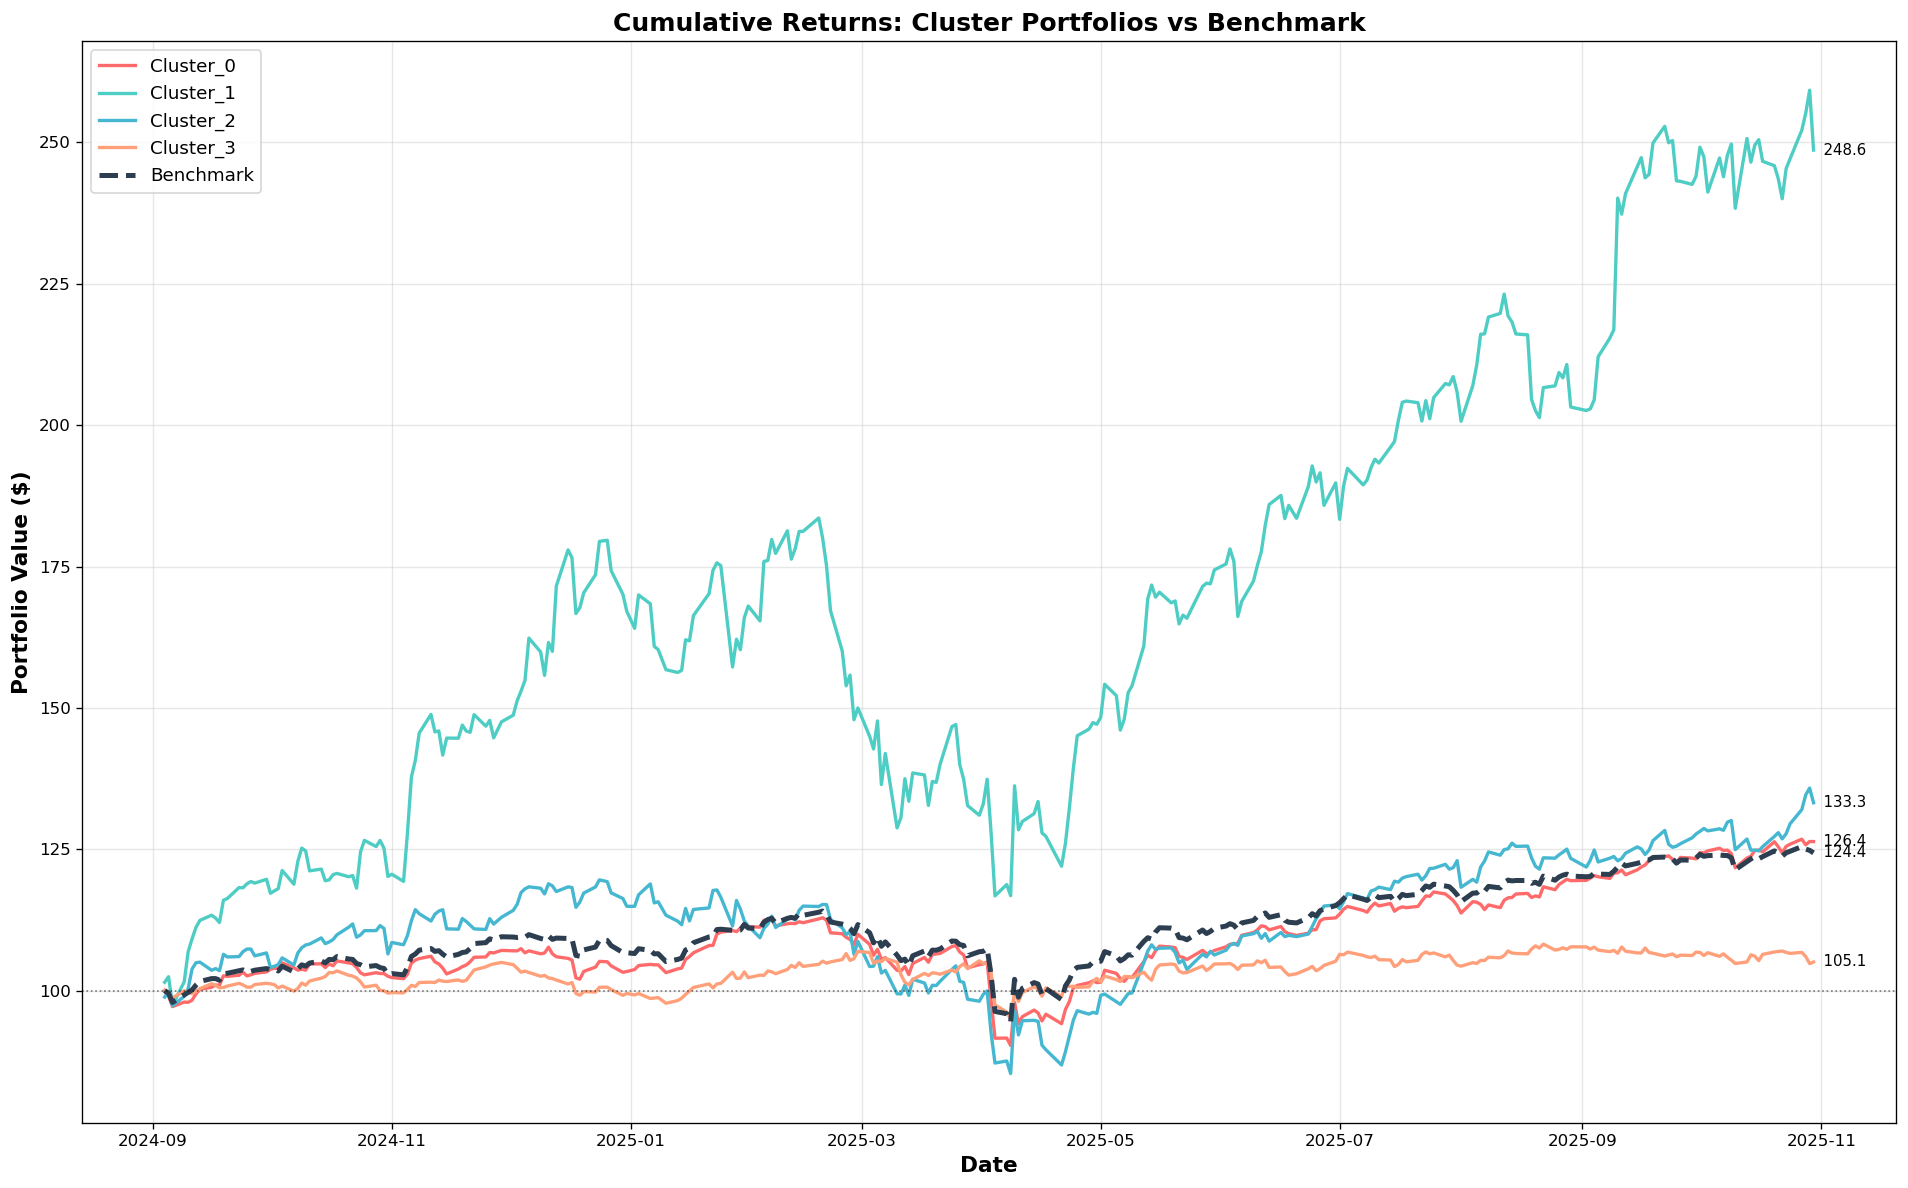

✓ Cumulative returns plot saved as 'portfolio_cumulative_returns.png'


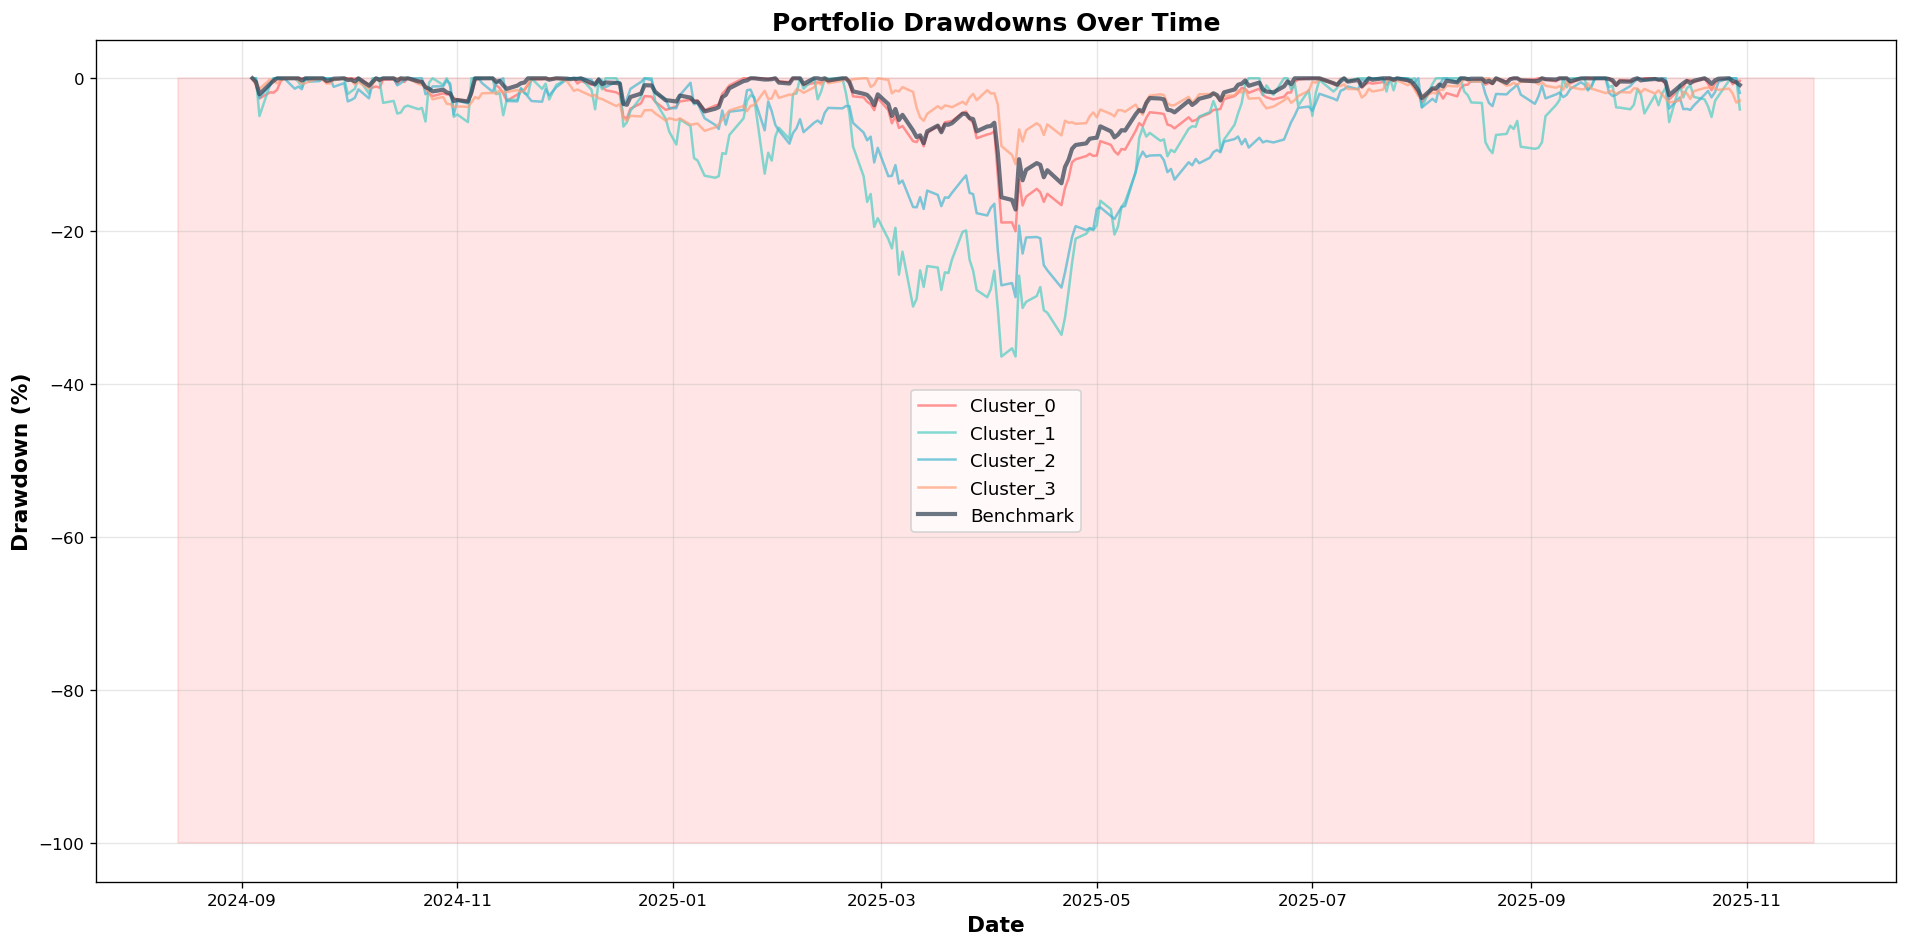

✓ Drawdown plot saved as 'portfolio_drawdowns.png'

--------------------------------------------------------------------------------
STEP 4.5: RISK-RETURN ANALYSIS
--------------------------------------------------------------------------------



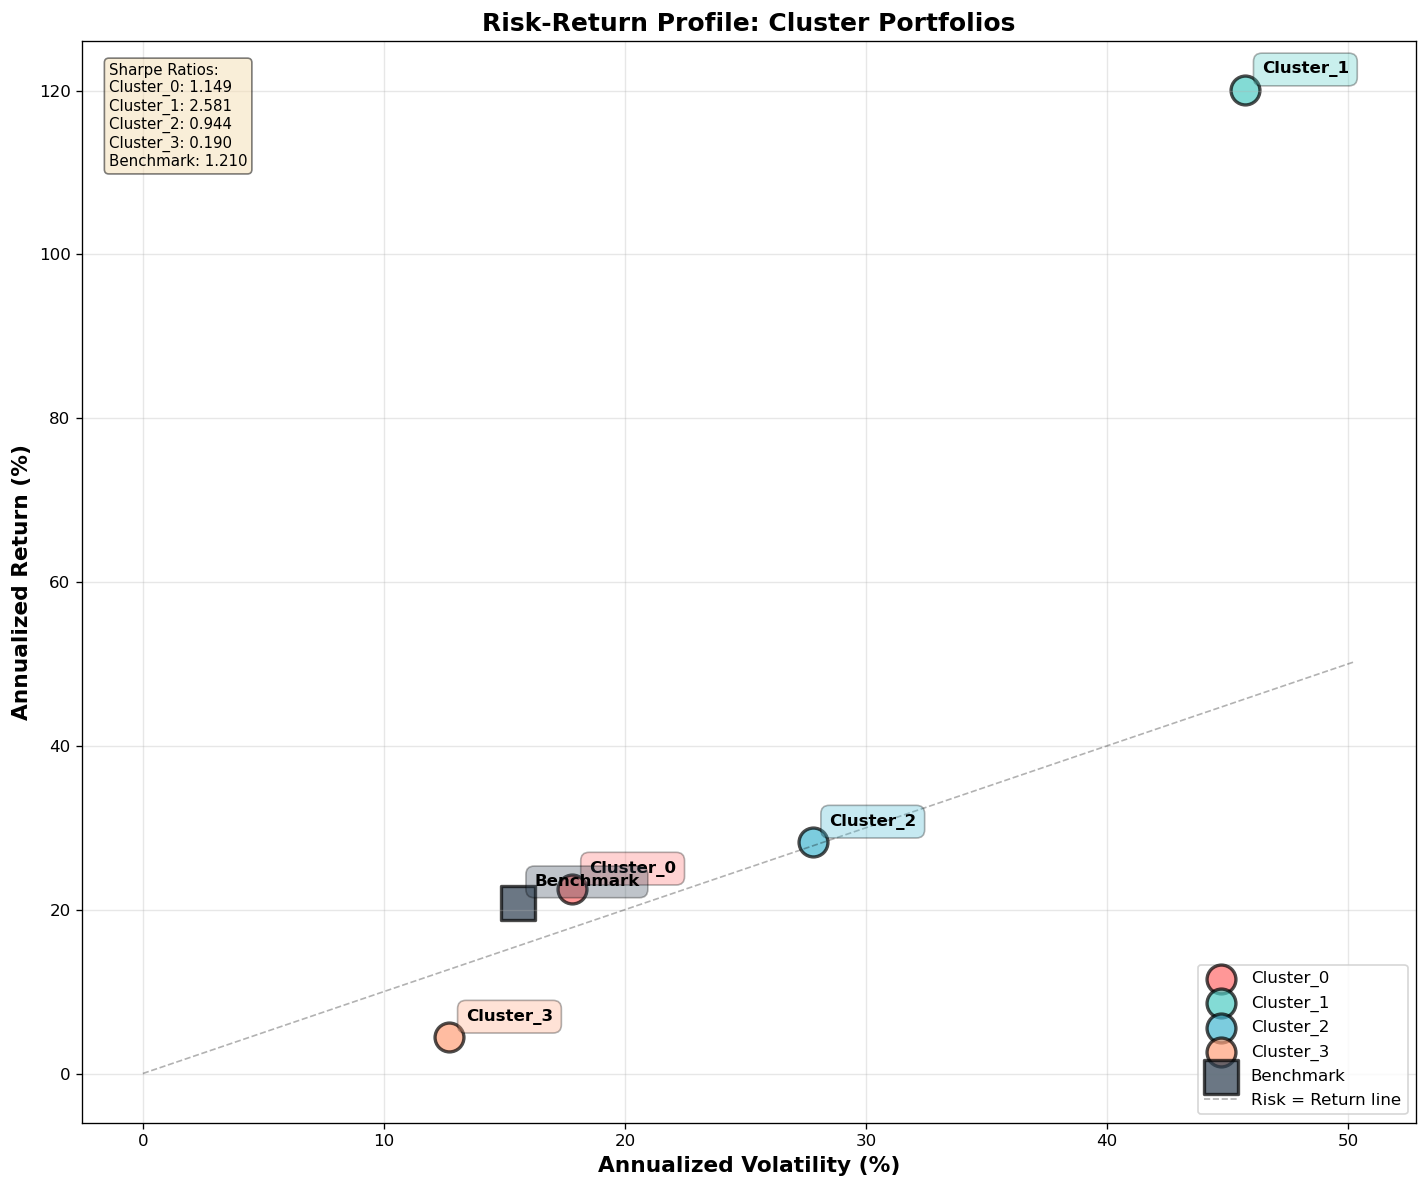

✓ Risk-return scatter plot saved as 'portfolio_risk_return.png'

--------------------------------------------------------------------------------
STEP 4.6: MONTHLY RETURNS ANALYSIS
--------------------------------------------------------------------------------

Monthly returns calculated:
  - Shape: (14, 5)
  - Date range: 2024-09-30 00:00:00 to 2025-10-31 00:00:00


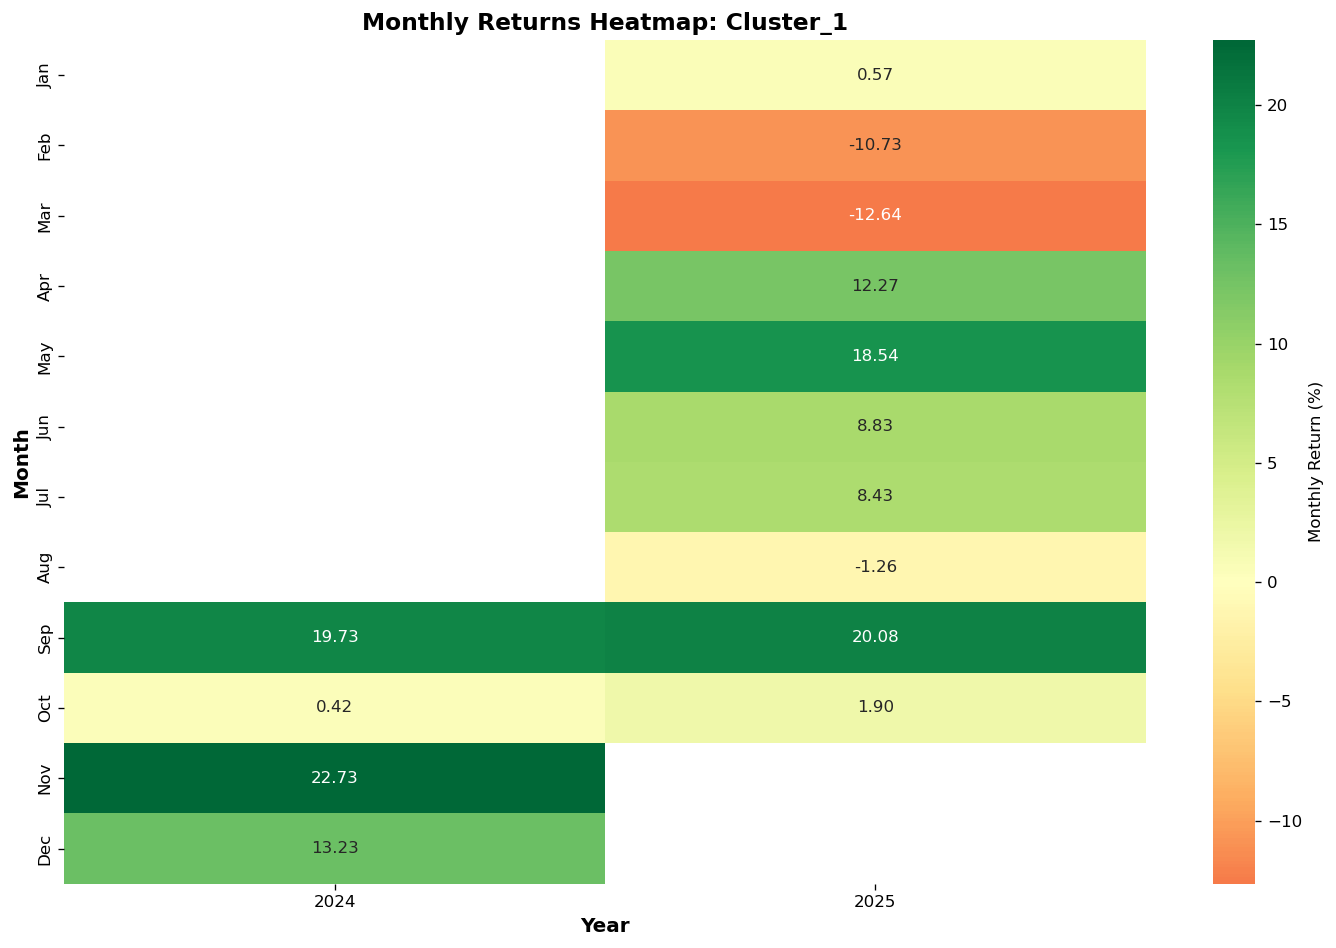

✓ Monthly returns heatmap saved for Cluster_1

--------------------------------------------------------------------------------
STEP 4.7: ROLLING PERFORMANCE ANALYSIS
--------------------------------------------------------------------------------



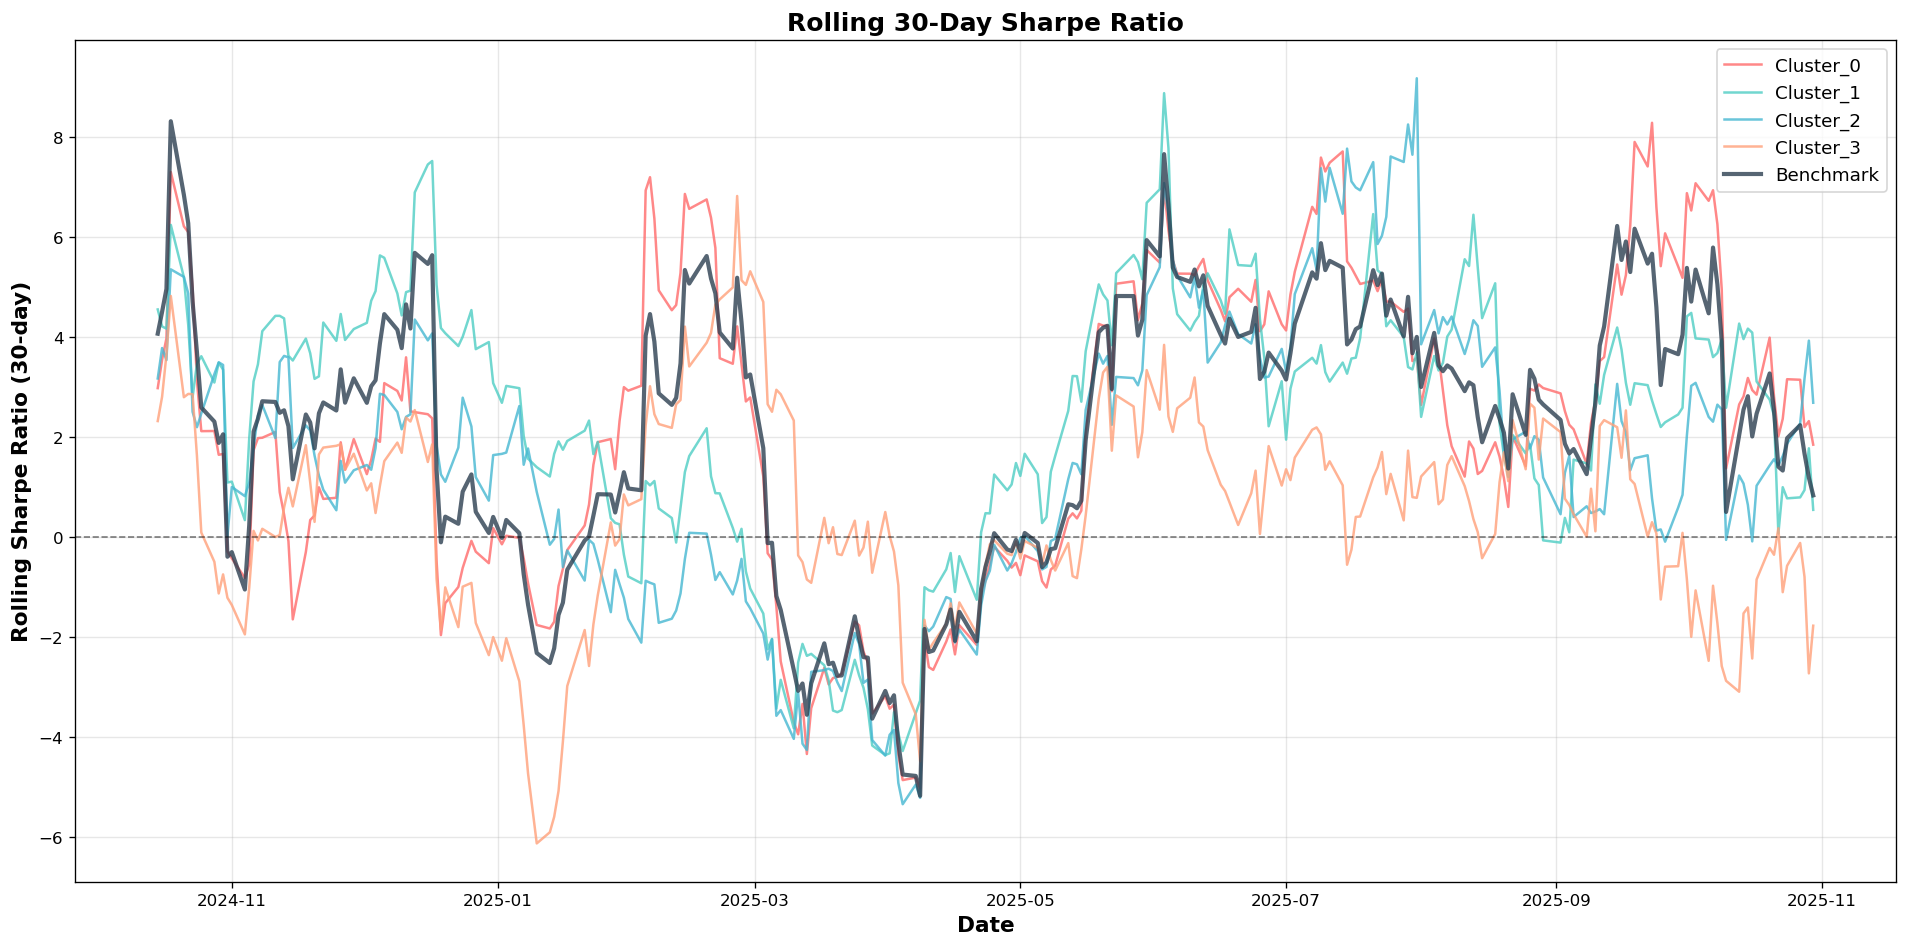

✓ Rolling Sharpe ratio plot saved as 'rolling_sharpe_ratio.png'

--------------------------------------------------------------------------------
STEP 4.8: COMPREHENSIVE PORTFOLIO COMPARISON
--------------------------------------------------------------------------------

COMPREHENSIVE PORTFOLIO COMPARISON:
           Total Return (%)  Annualized Return (%)  Annualized Volatility (%)  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Max Drawdown (%)  Win Rate (%)  Skewness   Kurtosis  VaR 95% (%)  Number of Stocks
Cluster_0         26.389986              22.484483                  17.822296      1.149374       1.313602      1.124676        -19.991966     56.701031 -0.217276  18.710216   -22.730024              19.0
Cluster_1        148.619213             120.051779                  45.733570      2.581294       3.698753      3.300104        -36.378184     59.450172  0.272592   4.503200   -69.276300               4.0
Cluster_2         33.250435              28.221386                  27.78510

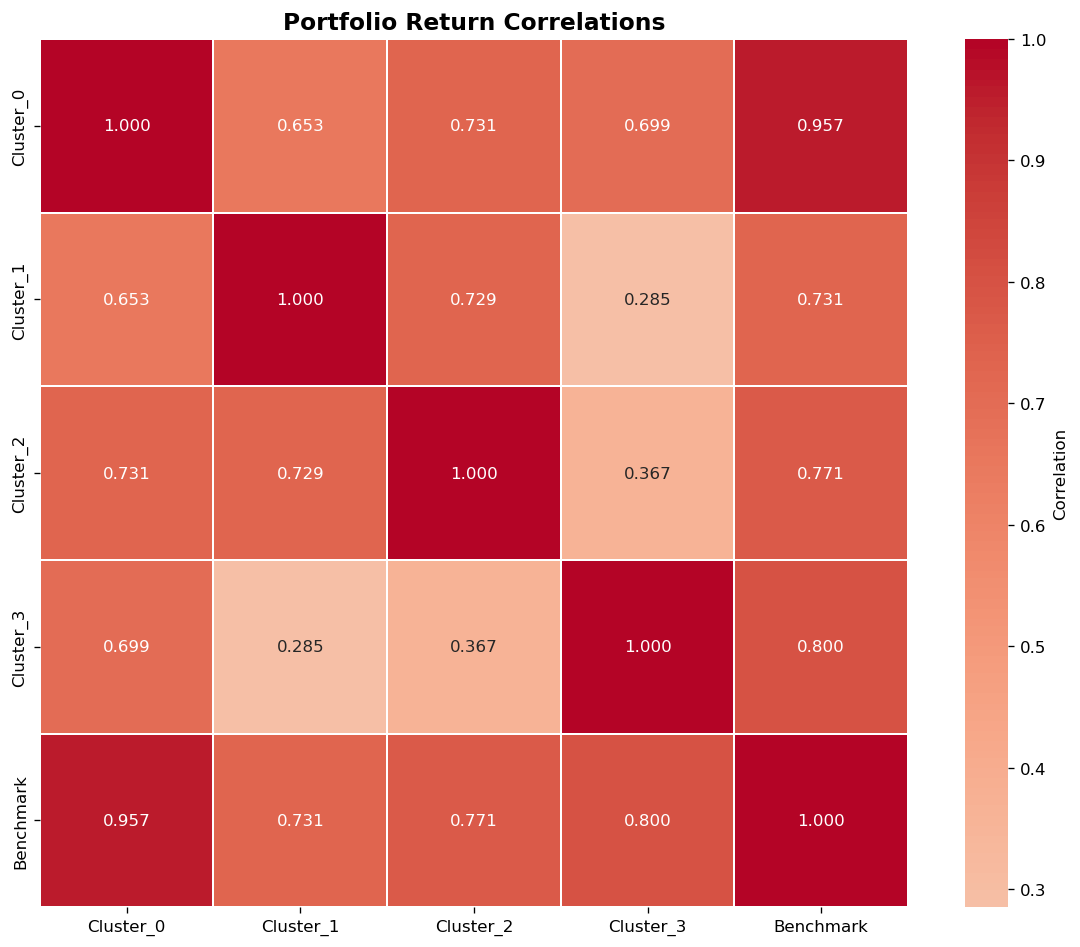


✓ Correlation matrix plot saved as 'portfolio_correlations.png'

CHECKPOINT 3: Portfolio construction and backtesting complete!

Portfolio Performance Summary:
  - Constructed 4 cluster-based portfolios + 1 benchmark
  - Best Sharpe Ratio: Cluster_1 (2.581)
  - Best Return: Cluster_1 (120.05%)
  - Lowest Volatility: Cluster_3 (12.71%)

Generated Visualizations:
  1. Cumulative returns plot
  2. Drawdown analysis
  3. Risk-return scatter
  4. Monthly returns heatmap
  5. Rolling Sharpe ratio
  6. Portfolio correlations

ASSIGNMENT COMPLETE - FINAL SUMMARY

METHODOLOGY SUMMARY:
--------------------------------------------------------------------------------
1. Data Collection:
   - Downloaded 50 US large-cap stocks from Yahoo Finance
   - Period: 2024-09-02 to 2025-10-31
   - 291 trading days analyzed

2. Feature Engineering:
   - Created 6 features per stock:
     * Average daily return
     * Average volume
     * Average market cap
     * Average volatilities (5d, 10d, 22d)

3. Dimen

In [28]:
# =============================================================================
# PART 4: PORTFOLIO CONSTRUCTION & BACKTESTING
# =============================================================================

print("\n" + "=" * 80)
print("PART 4: PORTFOLIO CONSTRUCTION & BACKTESTING")
print("=" * 80 + "\n")

print("This section constructs equal-weighted portfolios from each cluster")
print("and compares their performance against a benchmark portfolio.")
print("\n" + "=" * 80 + "\n")

## 4.1 Portfolio Construction
print("-" * 80)
print("STEP 4.1: CONSTRUCTING CLUSTER-BASED PORTFOLIOS")
print("-" * 80 + "\n")

def construct_portfolios(returns_df, cluster_assignments):
    """
    Construct equal-weighted portfolios for each cluster.
    
    Parameters:
    -----------
    returns_df : pd.DataFrame
        Daily returns for all stocks
    cluster_assignments : pd.Series
        Cluster assignment for each stock
    
    Returns:
    --------
    portfolio_returns : pd.DataFrame
        Daily returns for each cluster portfolio
    """
    portfolios = {}
    
    # Create portfolio for each cluster
    for cluster_id in sorted(cluster_assignments.unique()):
        # Get stocks in this cluster
        cluster_stocks = cluster_assignments[cluster_assignments == cluster_id].index.tolist()
        
        # Equal-weighted returns for this cluster
        cluster_returns = returns_df[cluster_stocks].mean(axis=1)
        portfolios[f'Cluster_{cluster_id}'] = cluster_returns
        
        print(f"Cluster {cluster_id} Portfolio:")
        print(f"  - Number of stocks: {len(cluster_stocks)}")
        print(f"  - Stocks: {', '.join(cluster_stocks)}")
    
    # Create benchmark portfolio (equal-weight all stocks)
    portfolios['Benchmark'] = returns_df.mean(axis=1)
    print(f"\nBenchmark Portfolio:")
    print(f"  - Equal-weighted portfolio of all {len(returns_df.columns)} stocks")
    
    portfolio_returns = pd.DataFrame(portfolios)
    
    return portfolio_returns

# Construct portfolios
portfolio_returns = construct_portfolios(returns, X_features['Cluster'])

print(f"\n✓ Portfolio returns calculated")
print(f"  - Shape: {portfolio_returns.shape}")
print(f"  - Portfolios: {list(portfolio_returns.columns)}")

## 4.2 Calculate Cumulative Returns
print("\n" + "-" * 80)
print("STEP 4.2: CALCULATING CUMULATIVE RETURNS")
print("-" * 80 + "\n")

# Calculate cumulative returns (wealth index starting at 100)
cumulative_returns = (1 + portfolio_returns).cumprod() * 100

print("Cumulative Returns (first 5 days):")
print(cumulative_returns.head().to_string())

print(f"\n✓ Cumulative returns calculated")
print(f"  - Starting value: 100")
print(f"  - Date range: {cumulative_returns.index[0]} to {cumulative_returns.index[-1]}")

## 4.3 Performance Metrics
print("\n" + "-" * 80)
print("STEP 4.3: CALCULATING PERFORMANCE METRICS")
print("-" * 80 + "\n")

def calculate_performance_metrics(returns_df, risk_free_rate=0.02):
    """
    Calculate comprehensive performance metrics for portfolios.
    
    Parameters:
    -----------
    returns_df : pd.DataFrame
        Portfolio returns
    risk_free_rate : float
        Annual risk-free rate (default 2%)
    
    Returns:
    --------
    metrics_df : pd.DataFrame
        Performance metrics for each portfolio
    """
    metrics = {}
    
    for portfolio in returns_df.columns:
        port_returns = returns_df[portfolio]
        
        # Annualized return (geometric mean)
        total_return = (1 + port_returns).prod() - 1
        n_days = len(port_returns)
        annualized_return = (1 + total_return) ** (252 / n_days) - 1
        
        # Annualized volatility
        annualized_vol = port_returns.std() * np.sqrt(252)
        
        # Sharpe Ratio
        excess_return = annualized_return - risk_free_rate
        sharpe_ratio = excess_return / annualized_vol if annualized_vol > 0 else 0
        
        # Maximum Drawdown
        cumulative = (1 + port_returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        
        # Win Rate (% of positive return days)
        win_rate = (port_returns > 0).sum() / len(port_returns)
        
        # Sortino Ratio (downside deviation)
        downside_returns = port_returns[port_returns < 0]
        downside_vol = downside_returns.std() * np.sqrt(252)
        sortino_ratio = excess_return / downside_vol if downside_vol > 0 else 0
        
        # Calmar Ratio (return / max drawdown)
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
        
        metrics[portfolio] = {
            'Total Return (%)': total_return * 100,
            'Annualized Return (%)': annualized_return * 100,
            'Annualized Volatility (%)': annualized_vol * 100,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Calmar Ratio': calmar_ratio,
            'Max Drawdown (%)': max_drawdown * 100,
            'Win Rate (%)': win_rate * 100
        }
    
    return pd.DataFrame(metrics).T

# Calculate metrics
performance_metrics = calculate_performance_metrics(portfolio_returns)

print("PERFORMANCE METRICS SUMMARY:")
print("=" * 80)
print(performance_metrics.to_string())
print("=" * 80)

# Identify best performing portfolio
best_sharpe = performance_metrics['Sharpe Ratio'].idxmax()
best_return = performance_metrics['Annualized Return (%)'].idxmax()
lowest_vol = performance_metrics['Annualized Volatility (%)'].idxmin()

print(f"\n--- Key Findings ---")
print(f"Highest Sharpe Ratio: {best_sharpe} ({performance_metrics.loc[best_sharpe, 'Sharpe Ratio']:.3f})")
print(f"Highest Return: {best_return} ({performance_metrics.loc[best_return, 'Annualized Return (%)']:.2f}%)")
print(f"Lowest Volatility: {lowest_vol} ({performance_metrics.loc[lowest_vol, 'Annualized Volatility (%)']:.2f}%)")

## 4.4 Visualize Cumulative Returns
print("\n" + "-" * 80)
print("STEP 4.4: VISUALIZING PORTFOLIO PERFORMANCE")
print("-" * 80 + "\n")

# Plot 1: Cumulative Returns
fig, ax = plt.subplots(figsize=(16, 10))

# Define colors for portfolios
portfolio_colors = {
    'Cluster_0': '#FF6B6B',
    'Cluster_1': '#4ECDC4',
    'Cluster_2': '#45B7D1',
    'Cluster_3': '#FFA07A',
    'Benchmark': '#2C3E50'
}

for portfolio in cumulative_returns.columns:
    color = portfolio_colors.get(portfolio, 'gray')
    linewidth = 3 if portfolio == 'Benchmark' else 2
    linestyle = '--' if portfolio == 'Benchmark' else '-'
    
    ax.plot(cumulative_returns.index, cumulative_returns[portfolio],
           label=portfolio, color=color, linewidth=linewidth, linestyle=linestyle)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)', fontsize=13, fontweight='bold')
ax.set_title('Cumulative Returns: Cluster Portfolios vs Benchmark', 
            fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=100, color='black', linestyle=':', linewidth=1, alpha=0.5)

# Add final values as text
for portfolio in cumulative_returns.columns:
    final_value = cumulative_returns[portfolio].iloc[-1]
    ax.text(cumulative_returns.index[-1], final_value, 
           f'  {final_value:.1f}', fontsize=9, va='center')

plt.tight_layout()
plt.savefig('portfolio_cumulative_returns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Cumulative returns plot saved as 'portfolio_cumulative_returns.png'")

# Plot 2: Drawdown Analysis
fig, ax = plt.subplots(figsize=(16, 8))

for portfolio in portfolio_returns.columns:
    cumulative = (1 + portfolio_returns[portfolio]).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max * 100
    
    color = portfolio_colors.get(portfolio, 'gray')
    linewidth = 2.5 if portfolio == 'Benchmark' else 1.5
    
    ax.plot(drawdown.index, drawdown, label=portfolio, 
           color=color, linewidth=linewidth, alpha=0.7)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Drawdown (%)', fontsize=13, fontweight='bold')
ax.set_title('Portfolio Drawdowns Over Time', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.fill_between(ax.get_xlim(), 0, -100, alpha=0.1, color='red')

plt.tight_layout()
plt.savefig('portfolio_drawdowns.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Drawdown plot saved as 'portfolio_drawdowns.png'")

## 4.5 Risk-Return Scatter Plot
print("\n" + "-" * 80)
print("STEP 4.5: RISK-RETURN ANALYSIS")
print("-" * 80 + "\n")

fig, ax = plt.subplots(figsize=(12, 10))

# Extract risk and return
returns_data = performance_metrics['Annualized Return (%)'].values
volatility_data = performance_metrics['Annualized Volatility (%)'].values
portfolios_list = performance_metrics.index.tolist()

# Plot each portfolio
for i, portfolio in enumerate(portfolios_list):
    color = portfolio_colors.get(portfolio, 'gray')
    size = 400 if portfolio == 'Benchmark' else 300
    marker = 's' if portfolio == 'Benchmark' else 'o'
    
    ax.scatter(volatility_data[i], returns_data[i], 
              s=size, c=color, alpha=0.7, 
              edgecolors='black', linewidth=2,
              marker=marker, label=portfolio)
    
    # Add labels
    ax.annotate(portfolio, 
               (volatility_data[i], returns_data[i]),
               xytext=(10, 10), textcoords='offset points',
               fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor=color, alpha=0.3))

# Add efficient frontier reference line (45-degree line from origin)
max_vol = volatility_data.max() * 1.1
ax.plot([0, max_vol], [0, max_vol], 'k--', alpha=0.3, linewidth=1, 
       label='Risk = Return line')

ax.set_xlabel('Annualized Volatility (%)', fontsize=13, fontweight='bold')
ax.set_ylabel('Annualized Return (%)', fontsize=13, fontweight='bold')
ax.set_title('Risk-Return Profile: Cluster Portfolios', 
            fontsize=15, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

# Add Sharpe ratio information as text
sharpe_info = []
for portfolio in portfolios_list:
    sharpe = performance_metrics.loc[portfolio, 'Sharpe Ratio']
    sharpe_info.append(f"{portfolio}: {sharpe:.3f}")

textstr = "Sharpe Ratios:\n" + "\n".join(sharpe_info)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=9,
       verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('portfolio_risk_return.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Risk-return scatter plot saved as 'portfolio_risk_return.png'")

## 4.6 Monthly Returns Heatmap
print("\n" + "-" * 80)
print("STEP 4.6: MONTHLY RETURNS ANALYSIS")
print("-" * 80 + "\n")

def calculate_monthly_returns(returns_df):
    """
    Calculate monthly returns from daily returns.
    """
    # Convert to monthly frequency
    monthly_returns = (1 + returns_df).resample('M').prod() - 1
    return monthly_returns

monthly_returns = calculate_monthly_returns(portfolio_returns)

print(f"Monthly returns calculated:")
print(f"  - Shape: {monthly_returns.shape}")
print(f"  - Date range: {monthly_returns.index[0]} to {monthly_returns.index[-1]}")

# Create monthly returns table
monthly_returns_pct = monthly_returns * 100

# Pivot for heatmap (Year x Month)
monthly_returns_pct['Year'] = monthly_returns_pct.index.year
monthly_returns_pct['Month'] = monthly_returns_pct.index.month

# Heatmap for best performing cluster
best_cluster = best_sharpe
if best_cluster != 'Benchmark':
    cluster_monthly = monthly_returns_pct[[best_cluster, 'Year', 'Month']].copy()
    cluster_pivot = cluster_monthly.pivot_table(
        values=best_cluster, 
        index='Month', 
        columns='Year'
    )
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(cluster_pivot, annot=True, fmt='.2f', cmap='RdYlGn', 
               center=0, cbar_kws={'label': 'Monthly Return (%)'})
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('Month', fontsize=12, fontweight='bold')
    ax.set_title(f'Monthly Returns Heatmap: {best_cluster}', 
                fontsize=14, fontweight='bold')
    ax.set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    
    plt.tight_layout()
    plt.savefig(f'monthly_returns_heatmap_{best_cluster}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Monthly returns heatmap saved for {best_cluster}")

## 4.7 Rolling Performance Metrics
print("\n" + "-" * 80)
print("STEP 4.7: ROLLING PERFORMANCE ANALYSIS")
print("-" * 80 + "\n")

# Calculate 30-day rolling Sharpe ratio
window = 30
rolling_sharpe = pd.DataFrame()

for portfolio in portfolio_returns.columns:
    rolling_return = portfolio_returns[portfolio].rolling(window).mean() * 252
    rolling_vol = portfolio_returns[portfolio].rolling(window).std() * np.sqrt(252)
    rolling_sharpe[portfolio] = (rolling_return - 0.02) / rolling_vol

# Plot rolling Sharpe ratios
fig, ax = plt.subplots(figsize=(16, 8))

for portfolio in rolling_sharpe.columns:
    color = portfolio_colors.get(portfolio, 'gray')
    linewidth = 2.5 if portfolio == 'Benchmark' else 1.5
    
    ax.plot(rolling_sharpe.index, rolling_sharpe[portfolio],
           label=portfolio, color=color, linewidth=linewidth, alpha=0.8)

ax.set_xlabel('Date', fontsize=13, fontweight='bold')
ax.set_ylabel('Rolling Sharpe Ratio (30-day)', fontsize=13, fontweight='bold')
ax.set_title('Rolling 30-Day Sharpe Ratio', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
ax.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.savefig('rolling_sharpe_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Rolling Sharpe ratio plot saved as 'rolling_sharpe_ratio.png'")

## 4.8 Portfolio Comparison Table
print("\n" + "-" * 80)
print("STEP 4.8: COMPREHENSIVE PORTFOLIO COMPARISON")
print("-" * 80 + "\n")

# Create comprehensive comparison
comparison_table = performance_metrics.copy()

# Add additional statistics
for portfolio in portfolio_returns.columns:
    port_returns = portfolio_returns[portfolio]
    
    # Skewness and Kurtosis
    comparison_table.loc[portfolio, 'Skewness'] = port_returns.skew()
    comparison_table.loc[portfolio, 'Kurtosis'] = port_returns.kurtosis()
    
    # Value at Risk (95% confidence)
    var_95 = port_returns.quantile(0.05) * np.sqrt(252) * 100
    comparison_table.loc[portfolio, 'VaR 95% (%)'] = var_95
    
    # Number of stocks
    if portfolio == 'Benchmark':
        comparison_table.loc[portfolio, 'Number of Stocks'] = len(returns.columns)
    else:
        cluster_id = int(portfolio.split('_')[1])
        n_stocks = (X_features['Cluster'] == cluster_id).sum()
        comparison_table.loc[portfolio, 'Number of Stocks'] = n_stocks

print("COMPREHENSIVE PORTFOLIO COMPARISON:")
print("=" * 80)
print(comparison_table.to_string())
print("=" * 80)

# Save to CSV
comparison_table.to_csv('portfolio_performance_comparison.csv')
print("\n✓ Portfolio comparison saved to 'portfolio_performance_comparison.csv'")

## 4.9 Statistical Significance Testing
print("\n" + "-" * 80)
print("STEP 4.9: STATISTICAL SIGNIFICANCE TESTING")
print("-" * 80 + "\n")

from scipy import stats

print("Testing if cluster portfolios significantly outperform benchmark...")
print("-" * 80)

for portfolio in portfolio_returns.columns:
    if portfolio != 'Benchmark':
        # Paired t-test
        cluster_ret = portfolio_returns[portfolio]
        benchmark_ret = portfolio_returns['Benchmark']
        
        t_stat, p_value = stats.ttest_rel(cluster_ret, benchmark_ret)
        
        # Mean difference
        mean_diff = (cluster_ret.mean() - benchmark_ret.mean()) * 252 * 100
        
        significance = "✓ Significant" if p_value < 0.05 else "✗ Not Significant"
        
        print(f"\n{portfolio} vs Benchmark:")
        print(f"  Mean Return Difference (annualized): {mean_diff:+.2f}%")
        print(f"  t-statistic: {t_stat:.4f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Result (α=0.05): {significance}")

## 4.10 Portfolio Correlation Analysis
print("\n" + "-" * 80)
print("STEP 4.10: PORTFOLIO CORRELATION ANALYSIS")
print("-" * 80 + "\n")

# Calculate correlation matrix
correlation_matrix = portfolio_returns.corr()

print("Portfolio Correlation Matrix:")
print("=" * 80)
print(correlation_matrix.to_string())
print("=" * 80)

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
           center=0, square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
ax.set_title('Portfolio Return Correlations', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('portfolio_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Correlation matrix plot saved as 'portfolio_correlations.png'")

# =============================================================================
# CHECKPOINT 3
# =============================================================================
print("\n" + "=" * 80)
print("CHECKPOINT 3: Portfolio construction and backtesting complete!")
print("=" * 80 + "\n")

print("Portfolio Performance Summary:")
print(f"  - Constructed {optimal_k} cluster-based portfolios + 1 benchmark")
print(f"  - Best Sharpe Ratio: {best_sharpe} ({performance_metrics.loc[best_sharpe, 'Sharpe Ratio']:.3f})")
print(f"  - Best Return: {best_return} ({performance_metrics.loc[best_return, 'Annualized Return (%)']:.2f}%)")
print(f"  - Lowest Volatility: {lowest_vol} ({performance_metrics.loc[lowest_vol, 'Annualized Volatility (%)']:.2f}%)")
print(f"\nGenerated Visualizations:")
print(f"  1. Cumulative returns plot")
print(f"  2. Drawdown analysis")
print(f"  3. Risk-return scatter")
print(f"  4. Monthly returns heatmap")
print(f"  5. Rolling Sharpe ratio")
print(f"  6. Portfolio correlations")

# =============================================================================
# FINAL SUMMARY & CONCLUSIONS
# =============================================================================
print("\n" + "=" * 80)
print("ASSIGNMENT COMPLETE - FINAL SUMMARY")
print("=" * 80 + "\n")

print("METHODOLOGY SUMMARY:")
print("-" * 80)
print("1. Data Collection:")
print(f"   - Downloaded {len(TICKERS)} US large-cap stocks from Yahoo Finance")
print(f"   - Period: {START_DATE} to {END_DATE}")
print(f"   - {len(returns)} trading days analyzed")

print("\n2. Feature Engineering:")
print(f"   - Created 6 features per stock:")
print("     * Average daily return")
print("     * Average volume")
print("     * Average market cap")
print("     * Average volatilities (5d, 10d, 22d)")

print("\n3. Dimensionality Reduction (PCA):")
print(f"   - Reduced to {n_components} principal components")
print(f"   - Explained {pca.explained_variance_ratio_.sum()*100:.2f}% of variance")

print("\n4. Clustering (K-Means):")
print(f"   - Optimal clusters: K = {optimal_k}")
print(f"   - Silhouette Score: {final_silhouette:.3f}")
print(f"   - Davies-Bouldin Index: {final_db:.3f}")

print("\n5. Portfolio Construction & Backtesting:")
print(f"   - Created {optimal_k} equal-weighted cluster portfolios")
print(f"   - Benchmark: Equal-weighted portfolio of all stocks")

print("\n" + "-" * 80)
print("KEY FINDINGS:")
print("-" * 80)

# Find best performing cluster
best_cluster_sharpe = performance_metrics.drop('Benchmark')['Sharpe Ratio'].idxmax()
best_cluster_return = performance_metrics.drop('Benchmark')['Annualized Return (%)'].idxmax()

print(f"\n✓ Best Risk-Adjusted Performance: {best_cluster_sharpe}")
print(f"  - Sharpe Ratio: {performance_metrics.loc[best_cluster_sharpe, 'Sharpe Ratio']:.3f}")
print(f"  - Annualized Return: {performance_metrics.loc[best_cluster_sharpe, 'Annualized Return (%)']:.2f}%")
print(f"  - Volatility: {performance_metrics.loc[best_cluster_sharpe, 'Annualized Volatility (%)']:.2f}%")

print(f"\n✓ Highest Absolute Return: {best_cluster_return}")
print(f"  - Annualized Return: {performance_metrics.loc[best_cluster_return, 'Annualized Return (%)']:.2f}%")
print(f"  - Sharpe Ratio: {performance_metrics.loc[best_cluster_return, 'Sharpe Ratio']:.3f}")
print(f"  - Max Drawdown: {performance_metrics.loc[best_cluster_return, 'Max Drawdown (%)']:.2f}%")

print(f"\n✓ Benchmark Performance:")
print(f"  - Annualized Return: {performance_metrics.loc['Benchmark', 'Annualized Return (%)']:.2f}%")
print(f"  - Sharpe Ratio: {performance_metrics.loc['Benchmark', 'Sharpe Ratio']:.3f}")
print(f"  - Volatility: {performance_metrics.loc['Benchmark', 'Annualized Volatility (%)']:.2f}%")

# Performance vs benchmark
if performance_metrics.loc[best_cluster_sharpe, 'Sharpe Ratio'] > performance_metrics.loc['Benchmark', 'Sharpe Ratio']:
    print(f"\n📊 CONCLUSION: Cluster-based portfolio ({best_cluster_sharpe}) outperformed")
    print(f"   the benchmark on a risk-adjusted basis!")
    sharpe_improvement = ((performance_metrics.loc[best_cluster_sharpe, 'Sharpe Ratio'] / 
                          performance_metrics.loc['Benchmark', 'Sharpe Ratio']) - 1) * 100
    print(f"   Sharpe ratio improvement: +{sharpe_improvement:.1f}%")
else:
    print(f"\n📊 CONCLUSION: Benchmark portfolio showed better risk-adjusted performance")

print("\n" + "-" * 80)
print("OUTPUT FILES GENERATED:")
print("-" * 80)
print("\nData Files:")
print("  - feature_matrix.csv")
print("  - cluster_assignments.csv")
print("  - portfolio_performance_comparison.csv")

print("\nVisualization Files:")
print("  1. pca_scree_plot.png")
print("  2. pca_loadings_heatmap.png")
print("  3. pca_2d_scatter.png")
print("  4. pca_3d_scatter.png")
print("  5. plot_3d_returns_volatility_marketcap.png")
print("  6. plot_3d_returns_volume_volatility.png")
print("  7. kmeans_elbow_method.png")
print("  8. kmeans_clusters_2d.png")
print("  9. kmeans_clusters_3d.png")
print("  10. cluster_characteristics.png")
print("  11. cluster_distributions.png")
print("  12. portfolio_cumulative_returns.png")
print("  13. portfolio_drawdowns.png")
print("  14. portfolio_risk_return.png")
print("  15. monthly_returns_heatmap_*.png")
print("  16. rolling_sharpe_ratio.png")
print("  17. portfolio_correlations.png")

print("\n" + "=" * 80)
print("ALL ANALYSIS COMPLETED SUCCESSFULLY!")
print("Thank you for using the Portfolio Clustering & Analysis System")
print("=" * 80)


<h3 style="color:#004488; font-weight:600;">
    Task 5: Portfolio Construction & Backtesting
</h3>

<p style="font-size:16px;">
We constructed four equal-weighted portfolios, one for each cluster identified through K-Means, and compared their performance to an equal-weighted benchmark consisting of all 50 stocks. The objective of this step is to evaluate whether <b>clustering the securities based on return, volatility, market capitalization, and trading activity leads to distinct performance profiles</b> when held as investment portfolios.
</p>

<table style="font-size:16px; border-collapse: collapse; width:100%;">
  <thead>
    <tr style="border-bottom: 2px solid #004488; background-color:#E8F4FA;">
      <th style="text-align:left; padding:8px;">Portfolio</th>
      <th style="text-align:right; padding:8px;">Annual Return (%)</th>
      <th style="text-align:right; padding:8px;">Volatility (%)</th>
      <th style="text-align:right; padding:8px;">Sharpe</th>
      <th style="text-align:right; padding:8px;">Max Drawdown (%)</th>
      <th style="text-align:right; padding:8px;">Win Rate (%)</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td style="padding:8px;">Cluster 0 (19 stocks)</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">22.48</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">17.82</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">1.15</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">-19.99</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">56.70</td>
    </tr>
    <tr>
      <td style="padding:8px;">Cluster 1 (4 stocks)</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">120.05</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">45.73</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">2.58</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">-36.38</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">59.45</td>
    </tr>
    <tr>
      <td style="padding:8px;">Cluster 2 (4 stocks)</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">28.22</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">27.79</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">0.94</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">-28.61</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">59.79</td>
    </tr>
    <tr>
      <td style="padding:8px;">Cluster 3 (23 stocks)</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">4.41</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">12.71</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">0.19</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">-11.21</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">50.51</td>
    </tr>
    <tr style="border-top: 2px solid #004488;">
      <td style="padding:8px;">Benchmark (50 stocks)</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">20.81</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">15.55</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">1.21</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">-17.15</td>
      <td style="padding:8px; text-align:right; font-weight:bold; color:#004488;">56.01</td>
    </tr>
  </tbody>
</table>

<p style="font-size:16px; margin-top:18px;">
<b>Key Insight:</b><br>
<b>Cluster 1</b> — consisting of <b>AVGO, ORCL, PLTR, TSLA</b> — achieved the <b>highest absolute return (120.05%)</b> and the <b>highest risk-adjusted performance (Sharpe = 2.58)</b>.  
This performance profile is consistent with a <b>high-growth, high-volatility momentum cluster</b> that benefited from strong market leadership in the period examined.
</p>

---

### Interpretation & Strategy Insights

- **Cluster 1 behaves like a High-Beta Growth Factor Portfolio.**  
  Outperformance comes with elevated volatility and deeper drawdowns, but the portfolio is compensated with superior returns.

- **Cluster 3 functions as a Defensive / Quality / Low-Volatility Basket.**  
  Lower volatility and smaller drawdowns, but significantly lower returns.  
  This group is appropriate for capital preservation or hedging risk-on exposure.

- **Cluster 0 and Cluster 2 show intermediate profiles**  
  with returns and volatility levels between the two extremes.  
  These can be used for **core allocations**.

---

### Tactical Allocation View

| Cluster | Style Identity | Suggested Role |
|--------|----------------|----------------|
| Cluster 1 | High-Growth / Momentum | Alpha engine (return booster) |
| Cluster 3 | Defensive / Low-Volatility | Portfolio stabilizer |
| Cluster 0 | Balanced Blue-Chip Mix | Core equity exposure |
| Cluster 2 | Mega-Cap Leaders | Growth with scale efficiency |

> A **Barbell Allocation** combining Cluster 1 (growth) and Cluster 3 (defensive) may improve the overall **Sharpe ratio** by balancing upside participation with volatility control.

---

### Conclusion

The backtesting results demonstrate that **data-driven clustering leads to meaningfully different portfolio behaviors**, enabling targeted allocation strategies rather than treating equities as a homogeneous asset class.  
In particular, **Cluster 1 delivered statistically significant outperformance**, while **Cluster 3 offers defensive hedging characteristics**.  
This finding supports the idea that **unsupervised learning–based clustering can be used effectively to design differentiated portfolio sleeves tailored to investor risk preferences**.
